# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## A Tale of Two Cities through ML

## Table of contents
* [Introduction: Business Problem](#Introduction)
* [Data](#Data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1.  Introduction: Business Problem <a name="Introduction"></a>

In this project we will attempt to evolve an approach to identify suitable Neighborhoods in Toronto for moving in from New York city (and vice versa, i.e.,  Neighborhoods in New York city for moving in from Toronto). People relocate due to various reasons like doing business, enjoying retired life, profession, studies etc. We would try to identify suitability of a Neighborhood depending on the purpose of relocation. 

The **target audience** will be the people living in New York and wanting to relocate to Toronto for various reasons such as the following : -

    a. People migrating for a similar or better quality of life
    b. Professionals shifting to the other city looking to stay close to the office
    c. International students looking for a place to live with certain amenities within a budget
    d. Businessman looking to open shop in the other city in a location which would offer good customer base and minimum competition

Likewise, the people living in Toronto and wanting to relocate to New York are also part of the **target audience** for this project.

Our approach for suggesting suitability of a neighborhood for relocation would be by mapping the objective of relocation to the categories of venues available in the neighborhood. This, in my opinion, would be a novel approach since there are other parameters (such as crime rate, cost of living, property cost etc) which are not being considered; rather, these aspects would be infered from the venue details. 


## 2. Data <a name="Data"></a>

2.1 **Data sources**.   The idea of the project is to first **understand user's (i.e. Target audience) requirements for relocation**, thereafter **know his /her present neighborhood** and finally **recommend a suitable neighborhood in the destination city** (New York or Toronto). To achieve the above objectives, following data sources will be used: -

> a. **Understand user's requirements**:  The user has to specify the following: -

>> i. **Purpose of relocation** (i.e., new business, better quality of life, education or profession). Each option             will imply a different set of neighborhood selection criteria

>> ii.  For the selected purpose of relocation, specify few characteristics of the neighborhood he / she would like to move in. This would help in narrowing down the recommended options: -

>>> - New business: Clientele would be high income group, medium income group or low income group

>>> - Better quality of life: Countryside, uptown or downtown

>>> - Education: Name of the University

>>> - Profession: Location of the Office where he / she would work

> b. **Know his /her present neighborhood**.  The user's current residential and office address. The residential address will be used to benchmark the "quality of life" (as a function of amenities available in the neighborhood). For this purpose, details of present neighborhood of the individual will be extracted out of his / her residential address using **Foursquare** app.
The office address will be used to obtain distance between office and residence. 

Neighborhood details obtained using **Foursquare** app have been discussed in succeeding paragraphs. 

> c. **Recommend a suitable neighborhood**. To recommend a suitable neighborhood, we would need details of all the neighborhoods in New York and Toronto. Neighborhood details would comprise of the following: -

>>  i. **Neighborhood details of Toronto and New York** - Borough, Neighborhood name, Neighborhood Latitude, Neighborhood Longitude  
>> For this purpose, following data sources will be used:-

>>> List of all neighborhoods of Toronto will be scraped from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

>>> However, the neighborhood dataset of Toronto available at this website does not contain Latitude, Longitude data of the neighborhoods. The Latitude, Longitude data will be retieved from the site http://cocl.us/Geospatial_data.

>>> List of all neighborhoods of New York will be scraped from the database maintained at https://cocl.us/new_york_dataset (courtesy: "Segmenting and Clustering Neighborhoods in New York City" Lab Exercise of week 3 of this Module) 


Importing / installing all necessary packages and libraries

In [31]:
pip install lxml

     |████████████████████████████████| 5.5MB 6.7MB/s eta 0:00:01█████████████████▋ | 5.3MB 6.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Importing all libraries required for data processing

In [1]:
import json    # to handle JSON files
from pandas.io.json import json_normalize  # transform JSON file into a pandas dataframe

import pandas as pd
import numpy as np

import re    # for string pattern search in venue categories

import requests    # for importing location data through Foursquare

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt  # for plotting 
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sb

Get Folium for map rendering 

In [2]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Install Nominatim for obtaining geographical coordinates of places

In [11]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

#### Toronto neighborhood data

In [2]:
#Download and save the web page into local directory
!wget -q -O 'Canada_data' https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
# The code was removed by Watson Studio for sharing.

> However, the database did not contain Latitude Longitude details of the neighborhoods. This data is essential to  obtain venue details through Foursquare app. The Latitude and Longitude data of each neighborhood based on Postal Codes were obtained from http://cocl.us/Geospatial_data. The combined database has been stored as "toronto_neigh". 

In [4]:
#Obtained lat, long info using the file mentioned in the Assignment
!wget -q -O "lat_long.csv" http://cocl.us/Geospatial_data

In [11]:
# The code was removed by Watson Studio for sharing.

#### New York neighborhood data

In [13]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [14]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#all the relevant data is in the features key, which is basically a list of the neighborhoods. Define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

In [15]:
# The code was removed by Watson Studio for sharing.

2.2 **Data cleaning**.  Data downloaded or scraped from the abovementioned sources were combined into one table for each city. Following data cleaning activities were carried out: -

> a. **Borough not assigned**. In this case, the neighborhood record were deleted.

> b. **Neighborhood not assigned**. In such cases, the neighborhood name was made the same as the borough.  

> c. **Duplicate entries of neighborhood** Duplicate entries of neighborhoods with different Postal Codes were found. On further investigation, it was seen that the neighborhoods with the same name were geographically distinct, i.e., North, South, East, West, Central etc. These corrections were made.

#### Toronto data cleaning

In [14]:
df = pd.read_csv('Canada_data.csv')
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# Checking for duplicates
toronto_dup=df[df.duplicated(['Borough', 'Neighborhood'])]
toronto_dup

,PostalCode,Borough,Neighborhood
20,M3C,North York,Don Mills
74,M3L,North York,Downsview
83,M3M,North York,Downsview
92,M3N,North York,Downsview


In [ ]:
# Correct Neighborhood names and their corresponding Postal Codes
M3B Don Mills North
M3C Don Mills South
M3M Downsview Central
M3L Downsview West
M3K Downsview East
M3H Downsview North

In [7]:
# Updating the database with correct neighborhood names
df['Neighborhood'][df['PostalCode']== 'M3B'] = 'Don Mills North'
df['Neighborhood'][df['PostalCode']== 'M3C'] = 'Don Mills South'
df['Neighborhood'][df['PostalCode']== 'M3K'] = 'Downsview East'
df['Neighborhood'][df['PostalCode']== 'M3L'] = 'Downsview West'
df['Neighborhood'][df['PostalCode']== 'M3M'] = 'Downsview Central'
df['Neighborhood'][df['PostalCode']== 'M3N'] = 'Downsview South'

In [8]:
# Verify after correction
df[df['Neighborhood'].str.contains('Don Mills')]

,PostalCode,Borough,Neighborhood
11,M3B,North York,Don Mills North
20,M3C,North York,Don Mills South


In [9]:
# Verify df after correction
toronto_dup=df[df.duplicated(['Borough', 'Neighborhood'])]
toronto_dup

,PostalCode,Borough,Neighborhood


After the above corrections, the dataframe was merged with lat_long database to create **"toronto_neigh"** dataframe.

In [ ]:
# Created one database having Toronto neighborhood data and lat long 
toronto_neigh = pd.merge(df, lat_long, how='inner', on='PostalCode')

toronto_neigh.reset_index(drop=True, inplace=True)

In [ ]:
# PostalCode info is not required. Instead, converting it into City column and fill it up with 'Toronto'
toronto_neigh.rename(columns = {'PostalCode': 'City'}, inplace=True)
toronto_neigh['City'] = 'Toronto'
toronto_neigh.head()

In [15]:
toronto_neigh.shape

(103, 5)

In [16]:
# Verify toronto_neigh to confirm the corrections made in df
toronto_dup=toronto_neigh[toronto_neigh['Neighborhood'].duplicated()]
toronto_dup

,City,Borough,Neighborhood,Latitude,Longitude


In [56]:
toronto_neigh.to_csv('toronto_cleaned.csv', index=False)

#### New York data cleaning

In [17]:
# Confirm whether Borrow and Neighborhood combination has any duplicate entries
newyork_dup=newyork_neigh[newyork_neigh.duplicated(['Borough', 'Neighborhood'])]
newyork_dup

,City,Borough,Neighborhood,Latitude,Longitude


In [18]:
# Same Neighborhood name, but Borrow is different
newyork_neigh[newyork_neigh['Neighborhood'] == 'Chelsea']

,City,Borough,Neighborhood,Latitude,Longitude
116,New York,Manhattan,Chelsea,40.744035,-74.003116
244,New York,Staten Island,Chelsea,40.594726,-74.189560


#### 2.3 Create a combined database on Toronto and New York neighborhoods.

The database of Toronto and New York were combined into one database "combined_data" so that the two cities can be compared and contrasted.

In [19]:
combined_data = toronto_neigh.append(newyork_neigh, ignore_index=True)
combined_data.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [24]:
combined_data.shape

(409, 5)

2.4 **Obtain list of prominent venues in each neighborhood**: This data will used to characterise various neighborhoods and compare them with the user's requirements for relocation. Following types of venues have been obtained for each neighborhood using **Foursquare** application: - 

> a. Public amenities (Departmental stores, Hospital, School, Bank, Post Office etc)

> b. Recreational & sports facilities (Sports centre, Cinema, Museum, Gym, Yoga studio etc.)

> c. Shopping malls, airport terminal, railway station

> d. Food joints (restaurant of various cuisines) 


#### **Venue Database using Foursquare App**

For each neighborhood in the combined database, details of all venues within 500 m radius were obtained using Foursquare app. The venue details include **name**, **latitude/longitude** and **category** of the venue.

In [20]:
# The code was removed by Watson Studio for sharing.

In [21]:
LIMIT = 100
RADIUS = 500

venues_list=[]
    
for i in range(combined_data.shape[0]):
    city = combined_data.loc[i, 'City']
    borough = combined_data.loc[i, 'Borough']
    name=combined_data.loc[i, 'Neighborhood']
    neigh_lat = combined_data.loc[i, 'Latitude']
    neigh_long = combined_data.loc[i, 'Longitude']

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neigh_lat, neigh_long, VERSION, RADIUS, LIMIT)

    results = requests.get(url).json()['response']['groups'][0]['items']
    
    venues_list.append([(
            city,
            borough,
            name, 
            neigh_lat, 
            neigh_long, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    combined_venues_raw = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    combined_venues_raw.columns = ['City', 'Borough', 
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    

In [22]:
combined_venues_raw.shape

(12288, 9)

In [23]:
combined_venues_raw.head()

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [24]:
combined_venues_raw[['Borough', 'Neighborhood']].nunique()

Borough          15
Neighborhood    401
dtype: int64

**Venue Database Cleaning**:  

>**Wrong venue details**. In some cases, the venue type was mentioned as "neighborhood" in the **Foursquare** data. Such records have been deleted.

In [25]:
combined_venues2 = combined_venues_raw[combined_venues_raw['Venue Category'] == 'Neighborhood']
combined_venues2

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
354,Toronto,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
606,Toronto,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
793,Toronto,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood
1268,Toronto,East Toronto,Studio District,43.659526,-79.340923,Leslieville,43.662070,-79.337856,Neighborhood
3494,New York,Brooklyn,Brighton Beach,40.576825,-73.965094,Little Russia,40.577690,-73.961580,Neighborhood
3498,New York,Brooklyn,Brighton Beach,40.576825,-73.965094,Brighton Beach,40.575518,-73.962372,Neighborhood
4642,New York,Brooklyn,Gerritsen Beach,40.590848,-73.930102,Gerritsen Beach,40.592377,-73.925009,Neighborhood
11972,New York,Queens,Roxbury,40.567376,-73.892138,"Roxbury, NY",40.566788,-73.891715,Neighborhood
12250,New York,Queens,Hammels,40.587338,-73.805530,"Rockaway Beach, NY",40.585899,-73.809066,Neighborhood


In [26]:
combined_venues = combined_venues_raw[combined_venues_raw['Venue Category'] != 'Neighborhood']
combined_venues

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...,...,...
12283,New York,Staten Island,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
12284,New York,Staten Island,Fox Hills,40.617311,-74.081740,Mona's Cuisine,40.618282,-74.084975,African Restaurant
12285,New York,Staten Island,Fox Hills,40.617311,-74.081740,Nettys playhouse,40.616856,-74.077566,Playground
12286,New York,Staten Island,Fox Hills,40.617311,-74.081740,Targee Milk & Things,40.614410,-74.084455,Grocery Store


2.5. **Pre-processing of Venues data**. Following pre-processing was performed with the venues data obtained by using **Foursquare** : - 
> a.   **Generalisation of venue types**. Venue details received through Four Square application was too specific. As a result there were about **462 'Venue Category'**. Such very detailed information on the venues were not necessary for meeting the project objectives, rather, it made the analysis very complex. Hence, the venues were further categorised into **16 generic categories**. E.g., there were more than **95 types of Restaurant**, besides another more than **33 venues which are various types of eatery**. These were classified into only **03 categories**, viz., **'Bakery and Cafe', 'Budget Food Joint'** and **'Restaurant'**. 

> b. **Additional attributes of the venues**. Additional attributes of the venue were recorded, e.g., the cuisine (such as Indian, Thai etc) in case of Food Joints. These will be used only if the individual has such specific requirements for stay / relocation. 
     
     

     I will experiment with the above pre-processed data and try to figure out whether the clustering results improved due to the pre-processing.


In [27]:
combined_venues['Venue Category'][combined_venues['Venue Category'].str.contains('Restaurant', case=False)].nunique()

96

In [28]:
venues_list = combined_venues['Venue Category'].unique()
venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['Venue']
venues_df['Category']="" 


#sports & fun
sports_entertainment = ['Entertainment', 'Surf Spot', 'Tennis Court', 'Recreation Center', 'Opera House', 'Racetrack', 'Soccer Field', 
                        'Playground', 'Music Venue', 'Multiplex', 
                        'Martial Arts Dojo', 'Jazz Club', 'Social Club', 'Cycle Studio', 'Concert Hall', 'Dance Studio', 'Comedy Club',
                        'Indoor Play Area', 'Exhibit', 'Skating Rink', 'Roller Rink', 'Rock Climbing Spot', 
                        'Event Space', 'Distribution Center', 'Curling Ice', 'Community Center', 'Convention Center', 'Go Kart', 
                        'Golf', 'Circus', 'Bike', 'Arcade', 'Pool', 'Stadium', 'Bowling', 'Board Shop', 'Sporting Goods Shop', 
                        'Comic Shop', 'Theater', 'Performing', 'Gaming', 'Sports', 'Volleyball', 'Hockey', 'Baseball', 'Basketball',]

# Health and wellness
health_wellness = ['Pilates Studio', 'Spa', 'Pharmacy', 'Non-Profit', 'Massage Studio', 'Medical Center', "Doctor's Office", 'Hospital', 'Eye Doctor', 
                   'Physical Therapist', 'Weight Loss Center', 'Gym', 'Health & Beauty Service', 'Bath House', 'Yoga Studio', ]

#"mall & plaza"
mall_plaza_supermarket = ['Supermarket', 'Plaza', 'Outlet Mall', 'Shopping Mall', 'Shopping Plaza', 'Big Box Store', 'Department Store']

#"lifestyle"
lifestyle = ['Boutique', 'Tattoo Parlor', 'Tanning Salon', 'Piercing Parlor', 'Pet Service', 'Strip Club', 'Other Nightlife', 'Lounge', 'Construction & Landscaping', 'Club House', 'Astrologer', 
             'Jewelry Store', 'Arts & Crafts Store', 'Accessories Store', 'Design Studio', 'Cosmetics Shop', 'Perfume Shop', 
             'Bridal Shop', 'Flower Shop', 'Gift Shop', 'Hobby Shop', 'Smoke Shop', 'Antique Shop', 'Record Shop']

#"Basic Needs" 
basic_needs = ['Photography Studio', 'Organic Grocery', 'Home Service', 'Dry Cleaner', 'Butcher', 'Bath House', 'Auto Garage', 'Store', 
               'Bubble Tea Shop', 'Cheese Shop', 'Chocolate Shop', 'Cupcake Shop', 'Dessert Shop', 'Donut Shop', 'Pie Shop', 
               'Ice Cream Shop', 'Frozen Yogurt Shop', 'Smoothie Shop', 'Optical Shop', 'Other Repair Shop', 'Print Shop', 
               'Supplement Shop', 'Tailor Shop', 'Gourmet Shop', 'Shop & Service', 'Mobile Phone Shop', 'Miscellaneous Shop',
               'Duty-free Shop', 'Auto Workshop', 'Automotive Shop', 'Bike Shop', 'Motorcycle Shop', 'Daycare', 'Laundromat', 
               'Laundry Service', 'Locksmith', 'Nail Salon', 'Tea Room', ]

# Market Place
market_place = ['Farmers Market', 'Fish Market', 'Flea Market', 'Market']   

# Touring Spot
Touring_Spot = ['Art Gallery', 'Museum', 'Tourist Information Center', 'Outdoor Sculpture', 'Memorial Site', 'Monument / Landmark', 'Historic Site', 'Beach', 'Auditorium', 'Aquarium',] 

# Public transport
pub_tpt = ['Rental Car Location', 'Airport', 'Train Station', 'Platform', 'Metro Station', 'Bus', 'Boat', 'Harbor', 'General Travel', 'Light Rail Station', 'Heliport', ] 
           
# Business Facility
business_factory_office = ['Coworking Space', 'Factory', 'IT Services', 'Office', ]      

# Budget eating joints
low_cost_food = ['Taco Place', 'Poutine Place', 'Snack Place', 'Food', 'Food Court', 'Food Stand', 'Food Truck', 'Fish & Chips', 
                 'Pizza', 'Joint', ]

# Lung Space
park_playgnd_lake = ['Scenic Lookout', 'Waterfront', "Outdoors & Recreation", 'Other Great Outdoors', 'Campground', 'Park', 'Dog Run', 'Lake', 'Garden', 
                     'Garden Center', ]

# Essential Services
essential_service = ['Veterinarian', 'Lawyer', 'Check Cashing Service', 'Gas Station', 'Bank', 'Post Office', 'Insurance Office', ]

# Restaurant
restaurant = ['Roof Deck', 'Poke Place', 'Steakhouse', 'Salad Place', 'Noodle House', 'Pool Hall', 'Dosa Place', 'Diner', 'Deli / Bodega', 'Creperie', 
              'Souvlaki', 'Restaurant', 'Food & Drink Shop', 'Buffet', 'Bistro',]

# Bakery and Cafe
backery_cafe = ['Bagel', 'Bakery','Breakfast Spot', 'Café', 'Sandwich', 'Burrito', 'Coffee', 'Cafeteria', 'Cha Chaan Teng',]

# Bar Pub etc 
bar_distil = ['Rock Club', 'Nightlife Spot', 'brewery', 'Nightclub', 'Distillery', 'Pub', 'beer', 'Bar', 'Wine Shop']

# Hotel Lodge etc
hotel_lodge = ['Resort', 'Motel', 'Event Service', 'Hotel', 'Boarding House', 'Bed', 'Hostel', ]

# Academic Institutes and Facilities
academic_facilities = ['Library', 'College', 'School', ]

# Religious Place
religious_place = ['Church', ]

# Residential building
residential = ['Residential Building', ]

# Ignore these categories
not_rel = ['Storage Facility', 'Waste Facility', 'Track', "Professional & Other Places", 'Summer Camp', 'Plane', 'Rest Area', 'Pier', 'River', 'Bridge', 'Intersection', 'Fountain',
           "Financial or Legal Service", 'Moving Target', 'Newsstand', ]

conflicts = ['Soup Place', 'field', 'building', 'farm', 'Market'] # these search strings must not be used aa these would conflict with other related search strings

cat_matrix = ['Bakery and Cafe', 'Residential building', 'Religious Place', 'Academic Institutes and Facilities', 
              'Hotel Lodge etc', 'Bar Pub etc', 'Restaurant', 'Essential Services', 'Lung Space', 'Market Place',
              'Health and Wellness', 'Basic Needs', 'lifestyle', 'mall_plaza_supermarket', 'sports and entertainment', 
              'Touring Spot', 'Public Tpt System', 'Business Facility', 'Budget Food Joint']
               

In [29]:

def category_convert(venues_df, n):
    venues_df['Generic Category'] = ''

    for i in range(venues_df.shape[0]):
        temp = venues_df.iloc[i,n]
        cont = 0
    
        for category in backery_cafe:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = 'Bakery and Cafe'
                cont = 1

        for category in academic_facilities:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Academic Institutes and Facilities"
                cont = 1

        for category in hotel_lodge:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Hotel Lodge etc"
                cont = 1

        for category in bar_distil:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Bar Pub etc"
                cont = 1

        for category in restaurant:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Restaurant"
                cont = 1

        for category in essential_service:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Essential Services"
                cont = 1

        for category in park_playgnd_lake:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Lung Space"
                cont = 1

        for category in market_place:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Market Place"
                cont = 1

        for category in health_wellness:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Health and Wellness"
                cont = 1

        for category in basic_needs:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Basic Needs"
                cont = 1

        for category in lifestyle:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "lifestyle"
                cont = 1

        for category in mall_plaza_supermarket:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "mall_plaza_supermarket"
                cont = 1

        for category in sports_entertainment:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "sports and entertainment"
                cont = 1

        for category in pub_tpt:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Public Tpt System"
                cont = 1

        for category in business_factory_office:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Business Facility"
                cont = 1

        for category in low_cost_food:
            if (re.search(category, temp, re.IGNORECASE)) and (cont == 0):
                venues_df.iloc[i, n+1] = "Budget Food Joint"
                cont = 1

        if cont == 0:
            venues_df.iloc[i, n+1] = "Ignored"

    return venues_df
                 

In [30]:
venue_gen_cat = category_convert(combined_venues, 8)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


> Following is the list of **Generic Categories**: -

In [31]:
gen_cat_list = venue_gen_cat.groupby(venue_gen_cat['Generic Category']).count()
gen_cat_list = pd.DataFrame(gen_cat_list.index)
gen_cat_list

,Generic Category
0,Academic Institutes and Facilities
1,Bakery and Cafe
2,Bar Pub etc
3,Basic Needs
4,Budget Food Joint
5,Business Facility
6,Essential Services
7,Health and Wellness
8,Hotel Lodge etc
9,Ignored


> Following venue categories were **ignored** as these were not relevant for the project: -

In [32]:
ignored_list =venue_gen_cat[venue_gen_cat['Generic Category'] == 'Ignored'].groupby(['Venue Category']).nunique()
ignored_list = pd.DataFrame(ignored_list.index)
ignored_list

,Venue Category
0,Aquarium
1,Art Gallery
2,Art Museum
3,Auditorium
4,Beach
5,Bridge
6,Building
7,Child Care Service
8,Church
9,Escape Room


> c. One-hot encoding to **convert Generic Categories** into numeric data  
> d. **Drop "Ignored"** venue category


In [33]:
# Create Neighborhood-wise dummies' table of venues
combined_venues_dummies=pd.concat([venue_gen_cat.iloc[:, 0:5], pd.get_dummies(venue_gen_cat['Generic Category'])], axis=1)
combined_venues_dummies.drop('Ignored', axis = 1, inplace=True)
combined_venues_dummies

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Academic Institutes and Facilities,Bakery and Cafe,Bar Pub etc,Basic Needs,Budget Food Joint,...,Essential Services,Health and Wellness,Hotel Lodge etc,Lung Space,Market Place,Public Tpt System,Restaurant,lifestyle,mall_plaza_supermarket,sports and entertainment
0,Toronto,North York,Parkwoods,43.753259,-79.329656,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Toronto,North York,Parkwoods,43.753259,-79.329656,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Toronto,North York,Victoria Village,43.725882,-79.315572,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Toronto,North York,Victoria Village,43.725882,-79.315572,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Toronto,North York,Victoria Village,43.725882,-79.315572,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12283,New York,Staten Island,Fox Hills,40.617311,-74.081740,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12284,New York,Staten Island,Fox Hills,40.617311,-74.081740,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12285,New York,Staten Island,Fox Hills,40.617311,-74.081740,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12286,New York,Staten Island,Fox Hills,40.617311,-74.081740,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


So, now we have the following databases, cleaned up and pre-processed, for further analysis and conclusion: -
  
>  a.  **combined_data** : Master database which contains details of all neighborhoods (limitation: as per data available through the Internet sources  

>  b.  **combined_venues** : Master database of venues within 500m radius of each neighborhood of the two cities.   

>  c.  **combined_venues_dummies** : Master database of venues combined into generic categories. Only the relevant generic categories were retained in the database.   



### Disclaimer:
**Foursquare** venue details are dynamic in nature. The **Venue** database will keep changing everytime it is refreshed by using **Foursquare** app. Hence the database instance was frozen at the time of project execution. There would be minor variations in the results whenever fresh data is obtained using **Foursquare**.

## 3. Methodology

In a nutshell, the approach can be summarised as follows: -  

1. Capture User's Requirements
2. Obtain Neighborhood data of Toronto
3. Obtain Neighborhood data of New York
3. Venue categorisation
4. Decide relevant venue attributes category-wise
5. Movement purpose-features matrix
6. Matching venue attributes with features

3.1 In this project, I will attempt to characterise each neighborhood of the two cities based on the venues such as restaurant, shops for daily need, gym and other health facilities, essential services etc. Availability and density of these venues will provide an indication of nature of the neighborhood. For example, availability of large number of restaurants and shops indicate that the neighborhood is a densely populated residential area. The analysis will be performed using the following two methods: -  

> a. **The conventional approach**: Using Exploratory Data Analysis techniques  

> b. **Machine Learning approach**: Using unsupervised learning technique - Clustering

  
3.2  **Aggregation of Venue Characterisitcs into Features**. The venues will be aggregated into **features**. Each feature is nothing but grouping of similar types of venues into a **generic category**. For example, restaurants of various cousines will be grouped into **Restaurant** generic category.
  
3.3 **Feature selection**.  Appropriate **features** will be selected which would map the neighborhood characteristics to the purpose of move of the migrating people. The **features** would be a sub-set of the neighborhood characteristics that meets the needs. The mapping is tabulated below: - 

    Purpose of Move                   | Features of Neighborhood
    :-------------------------------- | :---------------------------------------------------
    Quality of life                   | Lung Space (Park, Jogging track etc), lifestyle 
                                      | shopping, Recreational facilities
    Professionals                     | Hotel Lodge etc, Public Tpt System, Food Joints, 
                                      | public amenities
    International students            | Basic Needs, Budget Food Joint, sports 
                                      | and entertainment, transport facility    
    Businessman                       | availability of potential customer

  
    The neighborhoods whose features satisfy the purpose of move will be recommended for relocation.  
    
3.4 **Clustering**. Attempt will be made to cluster the neighborhoods into various groups based on their features. This would provide an opportunity to analyse the neighborhoods for their similarity and differences. 

## 4. Analysis

### Exploratory Data Analysis  
We  performed the following exploratory data analysis: -  
> The exploratory data analysis was carried out by **grouping** the dataset into **Neighborhoods** and summing up the venues under various **Generic Categories**.  

> Database of all neighborhoods was created as **top_venues** by taking the **top 10 venue categories** for each neighborhood.  

> **top_venues** was analysed to characterise each neighborhood. The database was also used to arrive at the most common venue categories available collectively in all the neighborhoods.  

> **Principal Component Analysis** was carried out to establish correlations between the various venue categories. The analysis provided a clue to what venues can be expected to co-exist in a neighborhood.  

> **Comparison between New York and Toronto**. Profiling of the two cities was carried out, i.e., which city has higher density of different venue categories, city-wise box-plot of venue distribution in various neighborhoods etc.  

### Neighborhood analysis based on **Features**   

After performing the abovementioned preliminary analysis, features were defined as described in **Para 3.3** and all neighborhoods were examined to figure out which features are present in each neighborhood. List of **Top 15** neighborhoods in each **Feature** was prepared.  

**These lists are the most important output of the Exploratory Data Analysis, which will be used by the individuals to make decision regarding which neighborhood to move in.** 

#### Grouping rows by neighborhood and taking the sum of venues of each category

In [34]:
combined_venues_grp=combined_venues_dummies.groupby(['City', 'Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'], sort=False, as_index=False)[list(combined_venues_dummies.columns)[5:]].sum().reset_index(drop=True)
combined_venues_grp

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Academic Institutes and Facilities,Bakery and Cafe,Bar Pub etc,Basic Needs,Budget Food Joint,...,Essential Services,Health and Wellness,Hotel Lodge etc,Lung Space,Market Place,Public Tpt System,Restaurant,lifestyle,mall_plaza_supermarket,sports and entertainment
0,Toronto,North York,Parkwoods,43.753259,-79.329656,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,Toronto,North York,Victoria Village,43.725882,-79.315572,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,15,5,4,0,...,1,4,1,3,1,0,3,1,0,4
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,1,0,8,0,...,0,1,0,0,0,0,1,2,0,0
4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,11,2,2,1,...,1,2,0,1,0,0,8,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,New York,Manhattan,Hudson Yards,40.756658,-74.000111,1,4,6,6,2,...,0,6,5,4,1,3,15,1,1,4
402,New York,Queens,Hammels,40.587338,-73.805530,0,0,0,1,2,...,0,1,0,1,0,2,3,0,0,0
403,New York,Queens,Bayswater,40.611322,-73.765968,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
404,New York,Queens,Queensbridge,40.756091,-73.945631,0,1,2,0,0,...,0,0,5,2,0,1,2,0,0,3


In [2]:
combined_venues_grp = pd.read_csv('combined_venues_grp.csv')

#### 4.1 Obtain top 10 most common venues for each neighborhood

In [3]:
top_venues_cnt=10
col=['City', 'Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']
top_venues=pd.DataFrame(columns=col)
top_venues['City'] = combined_venues_grp['City']
top_venues['Borough'] = combined_venues_grp['Borough']
top_venues['Neighborhood'] = combined_venues_grp['Neighborhood']
top_venues['Neighborhood Latitude'] = combined_venues_grp['Neighborhood Latitude']
top_venues['Neighborhood Longitude'] = combined_venues_grp['Neighborhood Longitude']

for i in range(combined_venues_grp.shape[0]):
    temp = combined_venues_grp[(combined_venues_grp['City']==combined_venues_grp['City'][i]) & (combined_venues_grp['Borough']==combined_venues_grp['Borough'][i]) & (combined_venues_grp['Neighborhood']==combined_venues_grp['Neighborhood'][i])].T.reset_index()
    temp = temp.iloc[5:,:]
    temp.columns=['venue', 'freq']
    temp['freq']=temp['freq'].astype('float')
    temp.sort_values('freq', ascending=False, inplace=True, na_position='last')
    temp = temp.reset_index(drop=True).head(top_venues_cnt)
    for j in range(top_venues_cnt):
        if temp.iloc[j, 1] != 0:
            top_venues.iloc[i, j+5] = temp.iloc[j, 0]

top_venues.head()

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Lung Space,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Toronto,North York,Victoria Village,43.725882,-79.315572,Bakery and Cafe,Budget Food Joint,Restaurant,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Bakery and Cafe,Basic Needs,Bar Pub etc,Health and Wellness,sports and entertainment,Lung Space,Restaurant,lifestyle,Essential Services,Market Place
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Basic Needs,lifestyle,Bakery and Cafe,Health and Wellness,Restaurant,NaN,NaN,NaN,NaN,NaN
4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Bakery and Cafe,Restaurant,Bar Pub etc,Basic Needs,Health and Wellness,sports and entertainment,Academic Institutes and Facilities,Budget Food Joint,Essential Services,Lung Space


In [4]:
venue_1st = top_venues['1st Most Common Venue'].value_counts()
venue_1st = pd.DataFrame(venue_1st)
venue_1st.reset_index(inplace= True)
venue_1st.columns = ['1st Most Common Venue', 'Count']

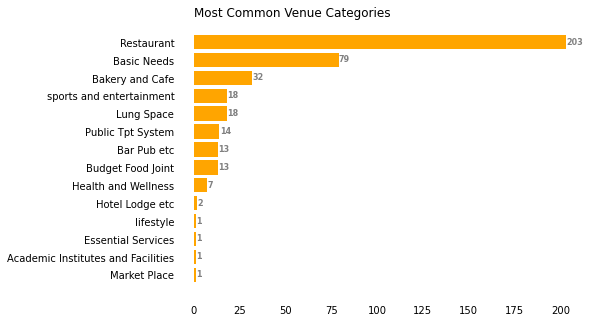

In [53]:
fig, ax = plt.subplots(figsize = (7, 5))

venue = venue_1st['1st Most Common Venue']
count = venue_1st['Count']

ax.barh(venue, count, color = 'orange')

ax.invert_yaxis() # Show top values  
    
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False)         # Remove axes splines 

ax.xaxis.set_ticks_position('none')     # Remove x, y Ticks 
ax.yaxis.set_ticks_position('none') 

# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 8) 
ax.yaxis.set_tick_params(pad = 16)

# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+.2, i.get_y()+.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 8, fontweight ='bold', 
             color ='grey') 

# Add Plot Title 
ax.set_title('Most Common Venue Categories', 
             loc ='left', ) 
  

plt.show()

In [11]:
venue_lifestyle = top_venues[(top_venues['1st Most Common Venue'] =='lifestyle') | (top_venues['1st Most Common Venue'] =='Lung Space')]
venue_lifestyle 

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Lung Space,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Toronto,York,Caledonia-Fairbanks,43.689026,-79.453512,Lung Space,Basic Needs,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Toronto,Scarborough,Scarborough Village,43.744734,-79.239476,lifestyle,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,Toronto,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,Lung Space,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,Toronto,Central Toronto,Roselawn,43.711695,-79.416936,Lung Space,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Toronto,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,Lung Space,Restaurant,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,Toronto,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,Lung Space,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Toronto,Downtown Toronto,Rosedale,43.679563,-79.377529,Lung Space,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Toronto,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Lung Space,Public Tpt System,Restaurant,Bakery and Cafe,Bar Pub etc,Basic Needs,Budget Food Joint,Health and Wellness,Market Place,sports and entertainment
103,New York,Bronx,Riverdale,40.890834,-73.912585,Lung Space,Public Tpt System,sports and entertainment,Basic Needs,Essential Services,Health and Wellness,mall_plaza_supermarket,NaN,NaN,NaN


In [12]:
venue_budget = top_venues[(top_venues['1st Most Common Venue'] =='Budget Food Joint')]
venue_budget 

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Toronto,North York,Downsview Central,43.728496,-79.495697,Budget Food Joint,Public Tpt System,Restaurant,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN
116,New York,Bronx,East Tremont,40.842696,-73.887356,Budget Food Joint,Basic Needs,Restaurant,lifestyle,Bakery and Cafe,Essential Services,Market Place,NaN,NaN,NaN
123,New York,Bronx,Hunts Point,40.809730,-73.883315,Budget Food Joint,Restaurant,Basic Needs,Bakery and Cafe,Bar Pub etc,Essential Services,Market Place,NaN,NaN,NaN
132,New York,Bronx,Morris Park,40.847549,-73.850402,Budget Food Joint,Restaurant,Bakery and Cafe,Bar Pub etc,Basic Needs,Essential Services,Health and Wellness,NaN,NaN,NaN
139,New York,Bronx,Castle Hill,40.819014,-73.848027,Budget Food Joint,Essential Services,Health and Wellness,Lung Space,Market Place,Restaurant,sports and entertainment,NaN,NaN,NaN
180,New York,Brooklyn,Dyker Heights,40.619219,-74.019314,Budget Food Joint,Bakery and Cafe,Lung Space,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN
243,New York,Queens,Glendale,40.702762,-73.870742,Budget Food Joint,Restaurant,Bar Pub etc,Basic Needs,NaN,NaN,NaN,NaN,NaN,NaN
306,New York,Staten Island,Castleton Corners,40.613336,-74.119181,Budget Food Joint,Basic Needs,Bakery and Cafe,Essential Services,Restaurant,sports and entertainment,Bar Pub etc,Public Tpt System,lifestyle,NaN
313,New York,Staten Island,Annadale,40.538114,-74.178549,Budget Food Joint,Restaurant,Basic Needs,Health and Wellness,Public Tpt System,NaN,NaN,NaN,NaN,NaN
343,New York,Staten Island,Bloomfield,40.605779,-74.187256,Budget Food Joint,Lung Space,Public Tpt System,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
venue_2nd = top_venues[top_venues['1st Most Common Venue'] =='Restaurant']['2nd Most Common Venue'].value_counts()
venue_2nd = pd.DataFrame(venue_2nd)
venue_2nd.reset_index(inplace= True)
venue_2nd.columns = ['2nd Most Common Venue', 'Count']

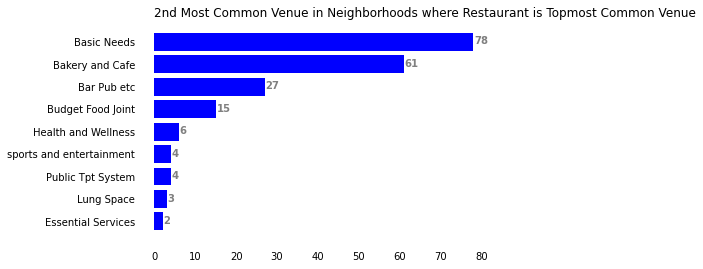

In [141]:
fig, ax = plt.subplots(figsize = (6, 4))

venue = venue_2nd['2nd Most Common Venue']
count = venue_2nd['Count']

ax.barh(venue, count, color = 'blue')

# Show top values  
ax.invert_yaxis() 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 8) 
ax.yaxis.set_tick_params(pad = 16)

# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+.2, i.get_y()+.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 10, fontweight ='bold', 
             color ='grey') 

# Add Plot Title 
ax.set_title('2nd Most Common Venue in Neighborhoods where Restaurant is Topmost Common Venue', 
             loc ='left', ) 
  

plt.show()

In [128]:
venue_3rd = top_venues[(top_venues['1st Most Common Venue'] =='Restaurant') & (top_venues['2nd Most Common Venue'] =='Basic Needs')]['3rd Most Common Venue'].value_counts()
venue_3rd = pd.DataFrame(venue_3rd)
venue_3rd.reset_index(inplace= True)
venue_3rd.columns = ['3rd Most Common Venue', 'Count']

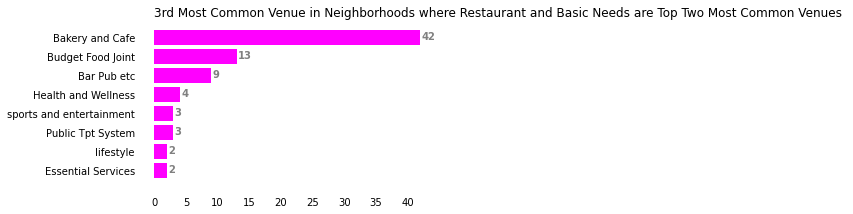

In [142]:
fig, ax = plt.subplots(figsize = (5, 3))

venue = venue_3rd['3rd Most Common Venue']
count = venue_3rd['Count']

ax.barh(venue, count, color = 'magenta')

# Show top values  
ax.invert_yaxis() 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 8) 
ax.yaxis.set_tick_params(pad = 16)

# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+.2, i.get_y()+.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 10, fontweight ='bold', 
             color ='grey') 

# Add Plot Title 
ax.set_title('3rd Most Common Venue in Neighborhoods where Restaurant and Basic Needs are Top Two Most Common Venues ', 
             loc ='left', ) 
  

plt.show()

In [149]:
venue_2nd_most = top_venues['2nd Most Common Venue'].value_counts()
venue_2nd_most

Basic Needs                           98
Bakery and Cafe                       82
Restaurant                            70
Budget Food Joint                     35
Bar Pub etc                           29
Public Tpt System                     18
Lung Space                            17
Health and Wellness                   13
sports and entertainment              12
lifestyle                              5
Essential Services                     5
mall_plaza_supermarket                 1
Hotel Lodge etc                        1
Academic Institutes and Facilities     1
Market Place                           1
Name: 2nd Most Common Venue, dtype: int64

In [150]:
venue_2nd_most = pd.DataFrame(venue_2nd_most)
venue_2nd_most.reset_index(inplace= True)
venue_2nd_most.columns = ['2nd Most Common Venue', 'Count']

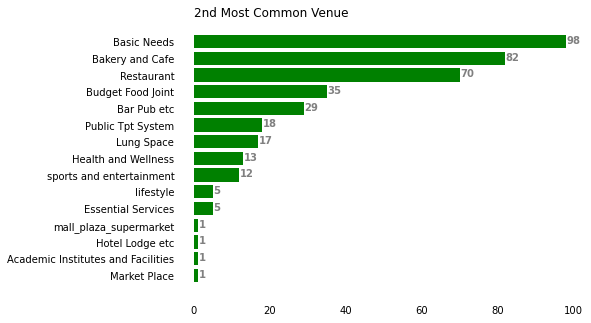

In [156]:
fig, ax = plt.subplots(figsize = (7, 5))

venue = venue_2nd_most['2nd Most Common Venue']
count = venue_2nd_most['Count']

ax.barh(venue, count, color = 'green')

# Show top values  
ax.invert_yaxis() 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 8) 
ax.yaxis.set_tick_params(pad = 16)

# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+.2, i.get_y()+.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 10, fontweight ='bold', 
             color ='grey') 

# Add Plot Title 
ax.set_title('2nd Most Common Venue', 
             loc ='left', ) 
  

plt.show()

In [154]:
venue_3rd_most = top_venues['3rd Most Common Venue'].value_counts()
venue_3rd_most

Bakery and Cafe                       94
Basic Needs                           71
Bar Pub etc                           43
Budget Food Joint                     41
Restaurant                            30
Public Tpt System                     23
Health and Wellness                   22
sports and entertainment              21
Lung Space                            10
Essential Services                     7
lifestyle                              6
Market Place                           3
Hotel Lodge etc                        2
Academic Institutes and Facilities     1
Name: 3rd Most Common Venue, dtype: int64

In [155]:
venue_3rd_most = pd.DataFrame(venue_3rd_most)
venue_3rd_most.reset_index(inplace= True)
venue_3rd_most.columns = ['3rd Most Common Venue', 'Count']

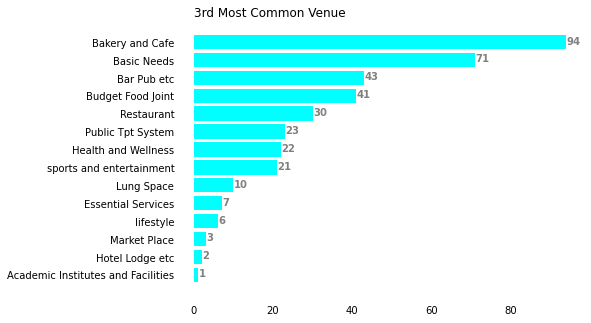

In [157]:
fig, ax = plt.subplots(figsize = (7, 5))

venue = venue_3rd_most['3rd Most Common Venue']
count = venue_3rd_most['Count']

ax.barh(venue, count, color = 'cyan')

# Show top values  
ax.invert_yaxis() 

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 8) 
ax.yaxis.set_tick_params(pad = 16)

# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+.2, i.get_y()+.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 10, fontweight ='bold', 
             color ='grey') 

# Add Plot Title 
ax.set_title('3rd Most Common Venue', 
             loc ='left', ) 
  

plt.show()

In [40]:
top_venues.to_csv('top_venues.csv', index=False)

**Findings:**  
>a. **"Restaurant"**, **"Basic Needs"** and **"Bakery and Cafe"** are the **three most common venues** in majority of the neighborhoods. Availability of these venues as the most common ones indicate that such neighborhoods are well-populated residential areas. Prefered by those who would relocate for jobs and decent living.    

>b. Neighborhoods with most common venues **"Lifestyle"** and **"Lung Space"** are the high-cost-of-living areas. Suitable for those looking to relocate for enjoying a relaxed and premium lifestyle. 

>c. The neighborhoods with **"Budget Food Joint"** as the  most common venue offers affordable living. Such neighborhoods would be prefered  by students for relocation.    



#### 4.2 Principal Component Analysis

In [18]:
combined_grp_cluster = combined_venues_grp.drop(['City', 'Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'], 1)
combined_grp_cluster.corr()

,Academic Institutes and Facilities,Bakery and Cafe,Bar Pub etc,Basic Needs,Budget Food Joint,Business Facility,Essential Services,Health and Wellness,Hotel Lodge etc,Lung Space,Market Place,Public Tpt System,Restaurant,lifestyle,mall_plaza_supermarket,sports and entertainment
Academic Institutes and Facilities,1.000000,0.273110,0.217849,0.240147,0.216905,0.047582,0.009586,0.318219,0.129053,0.126901,0.061791,-0.049502,0.237631,0.188437,0.241631,0.374877
Bakery and Cafe,0.273110,1.000000,0.737762,0.618654,0.543664,0.412513,0.050987,0.622283,0.558641,0.319036,0.272283,-0.117266,0.762029,0.518183,0.277125,0.495055
Bar Pub etc,0.217849,0.737762,1.000000,0.526034,0.576303,0.193508,-0.065558,0.594456,0.359991,0.341837,0.245189,-0.107607,0.776721,0.499645,0.109364,0.452290
Basic Needs,0.240147,0.618654,0.526034,1.000000,0.547292,0.189981,0.242183,0.587509,0.249592,0.168102,0.400624,-0.094104,0.680843,0.597858,0.256716,0.374617
Budget Food Joint,0.216905,0.543664,0.576303,0.547292,1.000000,0.106635,0.205309,0.506969,0.241650,0.177933,0.341761,-0.001795,0.634428,0.370825,0.108477,0.264799
Business Facility,0.047582,0.412513,0.193508,0.189981,0.106635,1.000000,-0.049339,0.123505,0.393222,0.181829,0.089214,0.009626,0.237622,0.178428,0.209863,0.248877
Essential Services,0.009586,0.050987,-0.065558,0.242183,0.205309,-0.049339,1.000000,0.081620,-0.093061,-0.075172,0.223649,0.081148,0.109874,0.028942,0.078734,-0.079387
Health and Wellness,0.318219,0.622283,0.594456,0.587509,0.506969,0.123505,0.081620,1.000000,0.459664,0.321960,0.266244,-0.124591,0.684473,0.528186,0.193354,0.462400
Hotel Lodge etc,0.129053,0.558641,0.359991,0.249592,0.241650,0.393222,-0.093061,0.459664,1.000000,0.214001,0.098906,0.015677,0.431154,0.346971,0.265940,0.368117
Lung Space,0.126901,0.319036,0.341837,0.168102,0.177933,0.181829,-0.075172,0.321960,0.214001,1.000000,0.146982,0.032052,0.319861,0.201169,0.256056,0.381037


In [11]:
combined_grp_cluster[['lifestyle', 'Health and Wellness', 'sports and entertainment', 'Lung Space']].corr()

,lifestyle,Health and Wellness,sports and entertainment,Lung Space
lifestyle,1.000000,0.528186,0.381296,0.201169
Health and Wellness,0.528186,1.000000,0.462400,0.321960
sports and entertainment,0.381296,0.462400,1.000000,0.381037
Lung Space,0.201169,0.321960,0.381037,1.000000


**Findings:**  
Following venue categories have **high correlation** (> 0.6): -  
> a. **"Bakery and Cafe"**, **"Bar Pub etc"**, **"Basic Needs"**, **"Health and Wellness"**, **"Restaurant"**  
This implies that neighborhoods which have any of these categories as the most common venues, are likely to have good number of venues of the remaining categories as well. 

Following venue categories are **moderately correlated** (0.45 to 0.55): -  
> a. **"lifestyle"**, **"Health and Wellness"**  
> b. **"Health and Wellness"**, **"sports and entertainment"**

**"Academic Institutes and Facilities"** do not have good correlation with any other venue category. This could imply that the university campus is self-sufficient and/or other venues (such as restaurant, basic needs etc) are located beyond radius of 500 metres. My database is built based on venues within a radius of 500 meters.  



#### 4.3 New York and Toronto data compare

**Cummulative numbers of venues in different Generic Categories**

In [5]:
city_comp = combined_venues_grp.iloc[:, 5:].groupby(combined_venues_grp['City']).sum().astype('int64')
city_comp

,Academic Institutes and Facilities,Bakery and Cafe,Bar Pub etc,Basic Needs,Budget Food Joint,Business Facility,Essential Services,Health and Wellness,Hotel Lodge etc,Lung Space,Market Place,Public Tpt System,Restaurant,lifestyle,mall_plaza_supermarket,sports and entertainment
City,,,,,,,,,,,,,,,,
New York,40,1069,783,1632,784,6,182,650,128,279,164,257,3073,303,59,469
Toronto,7,407,180,308,101,8,31,99,46,70,25,36,575,54,20,116


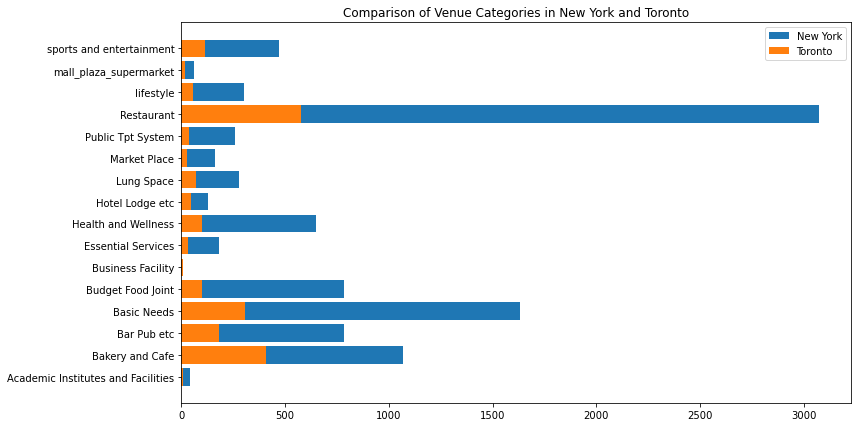

In [26]:
fig, ax = plt.subplots(figsize=(12, 7))

x1 = city_comp.columns
y1 = city_comp.loc['New York', :]
fig1 = ax.barh(x1, y1)
ax.invert_yaxis()

x2 = city_comp.columns
y2 = city_comp.loc['Toronto', :]
fig2 = ax.barh(x2, y2)
ax.invert_yaxis()

plt.legend((fig1[0], fig2[0]), ('New York', 'Toronto'))
plt.title('Comparison of Venue Categories in New York and Toronto')
plt.show()

**Findings: -**  
> a. In all generic categories, number of venues in New York are much more than Toronto.  

> b. For both New York and Toronto, the relative proportions of various generic category venues are very similar to each other  

> c. In both the cities, Restaurant is the most common venue among all generic categories. 

**Comparison of Neighborhood-wise distribution of venues in New York and Toronto**  
Four generic categories viz, "Restaurant", "sports and entertainment", "Lung Space"and "Basic Needs" were chosen for the analysis.

In [5]:
city_comp_box_T = combined_venues_grp[combined_venues_grp['City']=='Toronto'].iloc[:, 5:].groupby(combined_venues_grp['Neighborhood']).sum().astype('int64')
city_comp_box_T

city_comp_box_NY = combined_venues_grp[combined_venues_grp['City']=='New York'].iloc[:, 5:].groupby(combined_venues_grp['Neighborhood']).sum().astype('int64')
city_comp_box_NY

,Academic Institutes and Facilities,Bakery and Cafe,Bar Pub etc,Basic Needs,Budget Food Joint,Business Facility,Essential Services,Health and Wellness,Hotel Lodge etc,Lung Space,Market Place,Public Tpt System,Restaurant,lifestyle,mall_plaza_supermarket,sports and entertainment
Neighborhood,,,,,,,,,,,,,,,,
Allerton,1,1,0,6,6,0,2,2,0,0,2,1,6,0,0,1
Annadale,0,0,0,1,4,0,0,1,0,0,0,1,3,0,0,0
Arden Heights,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
Arlington,0,0,0,1,0,0,0,0,0,0,0,3,2,0,0,0
Arrochar,0,2,0,0,3,0,0,1,1,1,1,2,7,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodhaven,0,2,2,2,2,0,2,2,0,2,1,0,7,0,0,0
Woodlawn,0,1,3,2,3,0,0,0,0,1,0,2,6,1,1,1
Woodrow,1,3,1,4,0,0,1,2,0,0,0,0,5,2,0,0


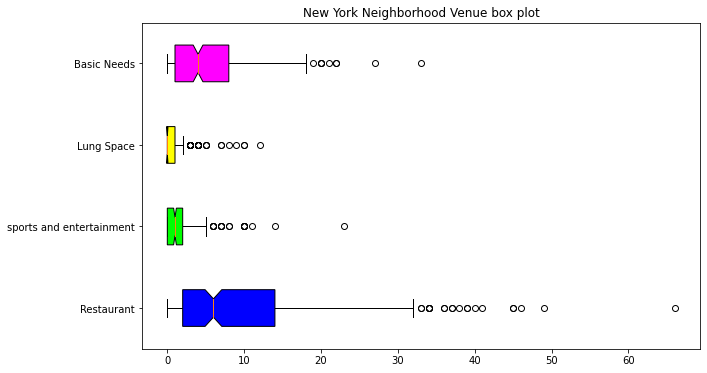

In [11]:
fig = plt.figure(figsize=(10, 6))

x1_NY = city_comp_box_NY['Restaurant']
x2_NY = city_comp_box_NY['sports and entertainment']
x3_NY = city_comp_box_NY['Lung Space']
x4_NY = city_comp_box_NY['Basic Needs']

NY_data = [x1_NY, x2_NY, x3_NY, x4_NY]

ax = fig.add_subplot(111) 

# Creating axes instance 
bp = ax.boxplot(NY_data, patch_artist = True, 
                notch ='True', vert = 0) 
  

colors = ['#0000FF', '#00FF00',  
          '#FFFF00', '#FF00FF' ] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 

# x-axis labels 
ax.set_yticklabels(['Restaurant', 'sports and entertainment',  
                    'Lung Space', 'Basic Needs']) 
  
# Adding title  
plt.title("New York Neighborhood Venue box plot") 
plt.show()

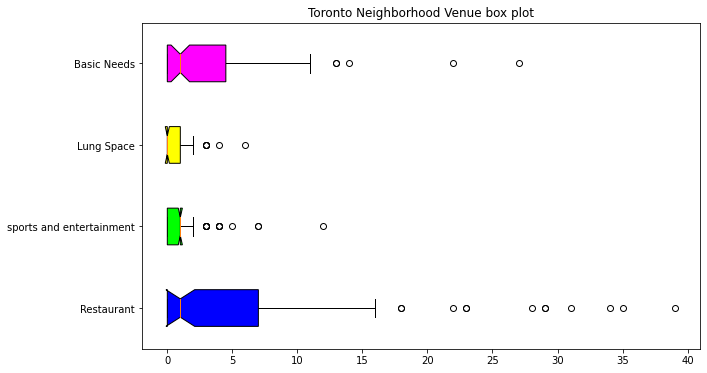

In [12]:
fig = plt.figure(figsize=(10, 6))

x1_T = city_comp_box_T['Restaurant']
x2_T = city_comp_box_T['sports and entertainment']
x3_T = city_comp_box_T['Lung Space']
x4_T = city_comp_box_T['Basic Needs']

T_data = [x1_T, x2_T, x3_T, x4_T]

ax = fig.add_subplot(111) 

# Creating axes instance 
bp = ax.boxplot(T_data, patch_artist = True, 
                notch ='True', vert = 0) 
  
colors = ['#0000FF', '#00FF00',  
          '#FFFF00', '#FF00FF'] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 

# x-axis labels 
ax.set_yticklabels(['Restaurant', 'sports and entertainment',  
                    'Lung Space', 'Basic Needs']) 
  
# Adding title  
plt.title("Toronto Neighborhood Venue box plot") 
plt.show()

**Findings: -**  
> a. In both the cities, the distribution is similar - with the inter-quartile range being quite close to  the first quartile.  

> b. In both the cities, the inter-quartile ranges of **"Restaurant"** and **"Basic Needs"** are much larger than **"Lung Space"** and **"sports and entertainment"**. Moreover, the inter-quartile ranges of **"Lung Space"** and **"sports and entertainment"(( are very close to zero. This indicates that majority of the neighborhoods do not have these two venue categories (within 500 m radius).  

> c. In case of New York, the median value for **"Basic Need"** and **"Restaurant"** are approximzately **5 and 6** respectively. However, in case of Toronto, these values are just about **one**. This indicates that the venue concentration in Toronto neighborhoods are much lower, as compared to New York.  

> d. In both the cities, Restaurant is the most common (generic category) venue

#### 4.4 Neighborhood Comparison based on Features

Effort was made to compare the neighborhoods based on the following features, which are representative of needs of the individual who is relocating: -  

> a. **eatery**: This is aggregation of **"Restaurant", "Bakery and Cafe", "Budget Food Joint" and "Bar Pub etc"**  
> b. **lifestyle**: Set of **"Lung Space" and "lifestyle"** venues  
> c. **daily_life**: Aggregation of **"Basic Needs", "Essential Services", "Market Place"** and **"mall_plaza_supermarket"**  
> d. **fitness**: Set of **"Health and Wellness"** and **"sports and entertainment"** venues.  
> e. **student_needs**:  Set of **"Academic Institutes and Facilities", "Basic Needs", "Budget Food Joint"** and **"sports and entertainment"**  
> f. **professionals_need**: Set of **"Business Facility", "Hotel Lodge etc"** and **"Public Tpt System"** venues.  

It is to be noted that, **eatery** and **daily_life** features are aggregations of different category venues, since these venues are of similar kinds. The remaining features are collections i.e., set of few venue categories which would collectively define that feature.  

The databases of features so created have been sorted in descending order to obtain the list of **top 15 neighborhoods for each feature**. In case of the features which are sets of venue categories, one category (which is considered as the most important attribute of the feature) has been chosen as the key for sorting and generating list of top 15 neighborhoods.



In [4]:
eatery=combined_venues_grp[['Restaurant', 'Bakery and Cafe', 'Budget Food Joint', 'Bar Pub etc']].groupby([combined_venues_grp['Borough'], combined_venues_grp['Neighborhood']]).sum().astype('int64')
eatery['Total Food venues'] = eatery.sum(axis = 1)
eatery_15 = eatery.sort_values('Total Food venues', ascending = False).head(15)
eatery_15

Restaurant  \
Borough          Neighborhood                                           
Queens           Astoria                                           49   
Manhattan        East Village                                      39   
Brooklyn         South Side                                        34   
Manhattan        Murray Hill                                       41   
Downtown Toronto Commerce Court, Victoria Hotel                    34   
                 First Canadian Place, Underground city            39   
                 Toronto Dominion Centre, Design Exchange          35   
Brooklyn         North Side                                        23   
                 Greenpoint                                        23   
                 Downtown                                          31   
Manhattan        Financial District                                28   
Brooklyn         Prospect Heights                                  33   
Manhattan        Upper West Side                                   37   
                 Turtle Bay                                        46   
Brooklyn         Carroll Gardens                                   28   

                                                           Bakery and Cafe  \
Borough          Neighborhood                                                
Queens           Astoria                                                10   
Manhattan        East Village                                            8   
Brooklyn         South Side                                             12   
Manhattan        Murray Hill                                            15   
Downtown Toronto Commerce Court, Victoria Hotel                         23   
                 First Canadian Place, Underground city                 20   
                 Toronto Dominion Centre, Design Exchange               24   
Brooklyn         North Side                                             16   
                 Greenpoint                                             13   
                 Downtown                                               13   
Manhattan        Financial District                                     17   
Brooklyn         Prospect Heights                                        9   
Manhattan        Upper West Side                                        13   
                 Turtle Bay                                              9   
Brooklyn         Carroll Gardens                                        14   

                                                           Budget Food Joint  \
Borough          Neighborhood                                                  
Queens           Astoria                                                   9   
Manhattan        East Village                                              8   
Brooklyn         South Side                                               11   
Manhattan        Murray Hill                                               7   
Downtown Toronto Commerce Court, Victoria Hotel                            4   
                 First Canadian Place, Underground city                    4   
                 Toronto Dominion Centre, Design Exchange                  2   
Brooklyn         North Side                                               11   
                 Greenpoint                                                6   
                 Downtown                                                 12   
Manhattan        Financial District                                       10   
Brooklyn         Prospect Heights                                          3   
Manhattan        Upper West Side                                           2   
                 Turtle Bay                                                1   
Brooklyn         Carroll Gardens                                           6   

                                                           Bar Pub etc  \
Borough          Neighborhood                          

In [5]:
lifestyle=combined_venues_grp[['Lung Space', 'lifestyle']].groupby([combined_venues_grp['Borough'], combined_venues_grp['Neighborhood']]).sum().astype('int64')
lifestyle_15 = lifestyle.sort_values('Lung Space', ascending=False).head(15)
lifestyle_15

Lung Space  \
Borough          Neighborhood                                                     
Brooklyn         Fulton Ferry                                                12   
Manhattan        Tribeca                                                     10   
Brooklyn         Dumbo                                                       10   
Manhattan        Tudor City                                                   9   
                 Battery Park City                                            8   
Brooklyn         Brooklyn Heights                                             7   
Manhattan        Turtle Bay                                                   7   
Downtown Toronto Harbourfront East, Union Station, Toronto Islands            6   
Bronx            Clason Point                                                 5   
Manhattan        West Village                                                 5   
                 Roosevelt Island                                             5   
East Toronto     Business reply mail Processing Centre, South Ce...           4   
Queens           Hunters Point                                                4   
Manhattan        Sutton Place                                                 4   
Bronx            Spuyten Duyvil                                               4   

                                                                     lifestyle  
Borough          Neighborhood                                                   
Brooklyn         Fulton Ferry                                                1  
Manhattan        Tribeca                                                     1  
Brooklyn         Dumbo                                                       1  
Manhattan        Tudor City                                                  1  
                 Battery Park City                                           1  
Brooklyn         Brooklyn Heights                                            6  
Manhattan        Turtle Bay                                                  2  
Downtown Toronto Harbourfront East, Union Station, Toronto Islands           1  
Bronx            Clason Point                                                0  
Manhattan        West Village                                                4  
                 Roosevelt Island                                            0  
East Toronto     Business reply mail Processing Centre, South Ce...          0  
Queens           Hunters Point                                               1  
Manhattan        Sutton Place                                                4  
Bronx            Spuyten Duyvil                                              0

In [6]:
daily_life=combined_venues_grp[['Basic Needs', 'Essential Services', 'Market Place', 'mall_plaza_supermarket']].groupby([combined_venues_grp['Borough'], combined_venues_grp['Neighborhood']]).sum().astype('int64')
daily_life['Total shopping venues'] = daily_life.sum(axis=1)
daily_life_15 = daily_life.sort_values('Total shopping venues', ascending=False).head(15)
daily_life_15

Basic Needs  \
Borough          Neighborhood                                
Bronx            Fordham                                33   
Downtown Toronto Garden District, Ryerson               27   
Manhattan        Soho                                   27   
Bronx            Belmont                                20   
Manhattan        Washington Heights                     21   
                 Chelsea                                21   
North York       Fairview, Henry Farm, Oriole           22   
Queens           Sunnyside Gardens                      17   
                 Bay Terrace                            19   
Brooklyn         Boerum Hill                            19   
Queens           Woodside                               20   
Manhattan        Flatiron                               20   
                 Chinatown                              18   
                 Little Italy                           18   
Brooklyn         Carroll Gardens                        16   

                                               Essential Services  \
Borough          Neighborhood                                       
Bronx            Fordham                                        5   
Downtown Toronto Garden District, Ryerson                       1   
Manhattan        Soho                                           0   
Bronx            Belmont                                        5   
Manhattan        Washington Heights                             2   
                 Chelsea                                        0   
North York       Fairview, Henry Farm, Oriole                   2   
Queens           Sunnyside Gardens                              2   
                 Bay Terrace                                    1   
Brooklyn         Boerum Hill                                    1   
Queens           Woodside                                       1   
Manhattan        Flatiron                                       0   
                 Chinatown                                      0   
                 Little Italy                                   0   
Brooklyn         Carroll Gardens                                1   

                                               Market Place  \
Borough          Neighborhood                                 
Bronx            Fordham                                  1   
Downtown Toronto Garden District, Ryerson                 0   
Manhattan        Soho                                     2   
Bronx            Belmont                                  3   
Manhattan        Washington Heights                       3   
                 Chelsea                                  4   
North York       Fairview, Henry Farm, Oriole             0   
Queens           Sunnyside Gardens                        4   
                 Bay Terrace                              1   
Brooklyn         Boerum Hill                              1   
Queens           Woodside                                 0   
Manhattan        Flatiron                                 1   
                 Chinatown                                2   
                 Little Italy                             2   
Brooklyn         Carroll Gardens                          2   

                                               mall_plaza_supermarket  \
Borough          Neighborhood                                           
Bronx            Fordham                                            3   
Downtown Toronto Garden District, Ryerson                           2   
Manhattan        Soho                                               0   
Bronx            Belmont                                            1   
Manhattan        Washington Heights                                 1   
                 Chelsea                                            1   
North York       Fairview, Henry Farm, Oriole                       1   
Queens           Sunnyside Gardens                                  0   
                

In [7]:
fitness = combined_venues_grp[['Health and Wellness', 'sports and entertainment']].groupby([combined_venues_grp['Borough'], combined_venues_grp['Neighborhood']]).sum().astype('int64')
fitness_15 = fitness.sort_values('Health and Wellness', ascending = False).head(15)
fitness_15

Health and Wellness  sports and entertainment
Borough   Neighborhood                                                     
Manhattan Civic Center                         16                         5
          Yorkville                            14                         3
Brooklyn  Brooklyn Heights                     14                         4
Queens    Forest Hills                         12                         0
Manhattan Carnegie Hill                        11                         3
          Clinton                              11                        14
          Sutton Place                         11                         4
          Murray Hill                          10                         1
Brooklyn  Boerum Hill                          10                        11
Manhattan Upper East Side                      10                         8
          Midtown South                         9                         2
          Midtown                               9                        10
          Flatiron                              9                         7
          Financial District                    8                         1
          Lincoln Square                        8                        23

In [9]:
student_needs = combined_venues_grp[['Academic Institutes and Facilities', 'Basic Needs', 'Budget Food Joint', 'sports and entertainment']].groupby([combined_venues_grp['Borough'], combined_venues_grp['Neighborhood']]).sum().astype('int64')
student_needs_15 = student_needs.sort_values('Academic Institutes and Facilities', ascending=False).head(15)
student_needs_15

Academic Institutes and Facilities  \
Borough          Neighborhood                                                                      
Manhattan        Lincoln Square                                                                3   
Queens           Hillcrest                                                                     2   
Downtown Toronto University of Toronto, Harbord                                                2   
Manhattan        Hamilton Heights                                                              2   
Brooklyn         Gowanus                                                                       1   
                 North Side                                                                    1   
Central Toronto  Lawrence Park                                                                 1   
Downtown Toronto Church and Wellesley                                                          1   
                 Garden District, Ryerson                                                      1   
                 Queen's Park, Ontario Provincial Government                                   1   
Manhattan        Flatiron                                                                      1   
Brooklyn         Gerritsen Beach                                                               1   
Manhattan        Battery Park City                                                             1   
                 Carnegie Hill                                                                 1   
                 Central Harlem                                                                1   

                                                              Basic Needs  \
Borough          Neighborhood                                               
Manhattan        Lincoln Square                                        13   
Queens           Hillcrest                                              7   
Downtown Toronto University of Toronto, Harbord                         4   
Manhattan        Hamilton Heights                                       3   
Brooklyn         Gowanus                                               10   
                 North Side                                            10   
Central Toronto  Lawrence Park                                          0   
Downtown Toronto Church and Wellesley                                   8   
                 Garden District, Ryerson                              27   
                 Queen's Park, Ontario Provincial Government            2   
Manhattan        Flatiron                                              20   
Brooklyn         Gerritsen Beach                                        5   
Manhattan        Battery Park City                                      7   
                 Carnegie Hill                                         12   
                 Central Harlem                                         3   

                                                              Budget Food Joint  \
Borough          Neighborhood                                                     
Manhattan        Lincoln Square                                               2   
Queens           Hillcrest                                                    2   
Downtown Toronto University of Toronto, Harbord                               0   
Manhattan        Hamilton Heights                                             7   
Brooklyn         Gowanus                                                      6   
                 North Side                                                  11   
Central Toronto  Lawrence Park                                                0   
Downtown Toronto Church and Wellesley                                         1   
                 Garden District, Ryerson                                     4   
                 Queen's Park, Ontario Provincial Government                  1   
Manhattan        Flatiron                              

In [10]:
professionals_need = combined_venues_grp[['Business Facility', 'Hotel Lodge etc', 'Public Tpt System']].groupby([combined_venues_grp['Borough'], combined_venues_grp['Neighborhood']]).sum().astype('int64') 
professionals_need_15 = professionals_need.sort_values('Business Facility', ascending=False).head(15)
professionals_need_15

Business Facility  \
Borough          Neighborhood                                                           
Downtown Toronto Harbourfront East, Union Station, Toronto Islands                  2   
Manhattan        Chelsea                                                            1   
Brooklyn         Vinegar Hill                                                       1   
Downtown Toronto Commerce Court, Victoria Hotel                                     1   
                 Richmond, Adelaide, King                                           1   
Queens           Long Island City                                                   1   
Downtown Toronto St. James Town                                                     1   
                 Garden District, Ryerson                                           1   
Queens           Steinway                                                           1   
Downtown Toronto Toronto Dominion Centre, Design Exchange                           1   
                 Central Bay Street                                                 1   
Manhattan        Tudor City                                                         1   
                 Flatiron                                                           1   
Queens           Jamaica Center                                                     0   
                 Jackson Heights                                                    0   

                                                                    Hotel Lodge etc  \
Borough          Neighborhood                                                         
Downtown Toronto Harbourfront East, Union Station, Toronto Islands                5   
Manhattan        Chelsea                                                          2   
Brooklyn         Vinegar Hill                                                     0   
Downtown Toronto Commerce Court, Victoria Hotel                                   6   
                 Richmond, Adelaide, King                                         3   
Queens           Long Island City                                                 9   
Downtown Toronto St. James Town                                                   2   
                 Garden District, Ryerson                                         2   
Queens           Steinway                                                         0   
Downtown Toronto Toronto Dominion Centre, Design Exchange                         8   
                 Central Bay Street                                               1   
Manhattan        Tudor City                                                       1   
                 Flatiron                                                         1   
Queens           Jamaica Center                                                   0   
                 Jackson Heights                                                  0   

                                                                    Public Tpt System  
Borough          Neighborhood                                                          
Downtown Toronto Harbourfront East, Union Station, Toronto Islands                  1  
Manhattan        Chelsea                                                            0  
Brooklyn         Vinegar Hill                                                       0  
Downtown Toronto Commerce Court, Victoria Hotel                                     1  
                 Richmond, Adelaide, King                                           1  
Queens           Long Island City                                                   1  
Downtown Toronto St. James Town                                                     0  
                 Garden District, Ryerson                                           0  
Queens           Steinway                                                           3  
Downtown Toronto Toronto Dominion Centre, Design Exchange                           2  
                 C

In [30]:
a = professionals_need_15.index.intersection(student_needs_15.index)
a = pd.DataFrame(a)
a.set_index('Neighborhood', inplace=True)
a

Index(['Chelsea', 'Flatiron'], dtype='object', name='Neighborhood')

In [31]:
b = daily_life_15.index.intersection(fitness_15.index)
b = pd.DataFrame(b)
b.set_index('Neighborhood', inplace=True)
b

Index(['Fordham', 'Boerum Hill', 'Flatiron'], dtype='object', name='Neighborhood')

In [32]:
c = lifestyle_15.index.intersection(eatery_15.index) 
c = pd.DataFrame(c)
c.set_index('Neighborhood', inplace=True)
c

Index(['Financial District'], dtype='object', name='Neighborhood')

In [34]:
d = a.index.intersection(b.index.intersection(c.index)) 
d

Index([], dtype='object', name='Neighborhood')

In [41]:
e = a.index.intersection(b.index) 
e

Index(['Flatiron'], dtype='object', name='Neighborhood')

In [40]:
f = b.index.intersection(c.index) 
f

Index([], dtype='object', name='Neighborhood')

In [39]:
g = a.index.intersection(c.index) 
g

Index([], dtype='object', name='Neighborhood')

**Findings: -**  

Scrutiny of the top 15 lists for various features reveals that these lists are largely **dis-joint** (i.e., **orthogonal**), except for a few neighborhoods which are as follows: -  

> a. Neighborhoods **Chelsea** and **Flatiron** are among the top 15 in **Professional** and **student** features  

> b. Neighborhoods **Fordham**, **Boerum Hill** and **Flatiron** are among the top 15 in **daily_life** and **fitness** features  

> c. Neighborhoods **Financial District** is among the top 15 in **lifestyle** and **eatery**  

> d. There is no neighborhood which is in top 15 in all features.  

**Conclusion**: The above findings imply that each neighborhood (except 05 neighborhoods mentioned above) has characteristics which quite uniquely belong to only one feature. So, an individual, who is relocating from another neighborhood will choose distinctly different neighborhood depending on his / her purpose of relocation.


**Outliers**.  

> a. The following neighborhoods have very low density of eatery venues (zero within 500 m radius). One needs to be very selective / cautious in choosing these neighborhoods for relocation, since conveniences may not be located near-by. 

In [17]:
eatery[eatery['Total Food venues']==0]

,Restaurant,Bakery and Cafe,Budget Food Joint,Bar Pub etc,Total Food venues
Neighborhood,,,,,
Bayswater,0,0,0,0,0
Bergen Beach,0,0,0,0,0
Breezy Point,0,0,0,0,0
Butler Manor,0,0,0,0,0
Downsview South,0,0,0,0,0
Downsview West,0,0,0,0,0
"East Toronto, Broadview North (Old East York)",0,0,0,0,0
Fieldston,0,0,0,0,0
Howland Hook,0,0,0,0,0


> b. The following neighborhoods, which are the last 10 in the **lifestyle** feature list have **zero "Lung Space" and zero / one "lifestyle" venues**. The **daily_life** feature of these neighborhoods were explored. It was found that even the **daily_life** feature is not prominent, indicating that these neighborhoods may not be suitable for relocation from another city.

In [20]:
lifestyle_last10 = lifestyle.sort_values('Lung Space', ascending=True).head(10)
lifestyle_last10

,Lung Space,lifestyle
Neighborhood,,
Agincourt,0,1
Mount Hope,0,0
Mott Haven,0,1
Morrisania,0,0
Morris Park,0,0
Morris Heights,0,0
"Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West",0,1
Murray Hill,0,2
Mill Island,0,0


In [28]:
daily_life.reset_index(inplace = True)
lifestyle_last10.reset_index(inplace = True)
ls_others = lifestyle_last10.join(daily_life.set_index(['Neighborhood']), on=['Neighborhood'])   
ls_others

,Neighborhood,Lung Space,lifestyle,Basic Needs,Essential Services,Market Place,mall_plaza_supermarket,Total shopping venues
0,Agincourt,0,1,0,0,0,0,0
1,Mount Hope,0,0,6,0,1,0,7
2,Mott Haven,0,1,6,0,0,0,6
3,Morrisania,0,0,7,0,1,0,8
4,Morris Park,0,0,2,1,0,0,3
5,Morris Heights,0,0,1,1,0,0,2
6,"Mimico NW, The Queensway West, South of Bloor,...",0,1,5,0,0,0,5
7,Murray Hill,0,2,10,2,2,0,14
8,Mill Island,0,0,0,0,0,0,0
9,Midwood,0,0,4,0,0,0,4


#### 4.5 Cluster Neighborhoods

Exploratory Data Analysis has helped us to identify top 15 neighborhoods for each feature that an individual would look for to relocate in the neighborhood. The analysis has also provided an insight into the most prominent venues. Besides, the two cities could be compared in terms of the venues to figure out which one is busier, more populated and with more amenities.  

Next, we applied **k-means Clustering Machine Learning algorithm** to create **clusters** of the neighborhoods based on the **combined_venues_grp** database. The database was clustered into 7 clusters as follows: -  
 - **Scaling** of database was performed since the counts of few venues (such as restaurant) were too high. Without scaling, the clustering would have been dominated by such venues.
 - **Number of clusters (knn)** was selected by applying **Elbow Method** using **intertia** and **distortion** parameters   
 - For optimum result, **init='k-means++'** was chosen

The cluster labels (obtained through k-means Clustering) were inserted into **top_venues** and **combined_venues_grp** databases to obtain a database of neighborhoods **combined_data_cluster** with their cluster labels and venue counts in each category.  

The individual clusters were analysed to obtain the following: -  
- Which **features** (out of **'eatery', 'lifestyle', 'professionals', 'student', 'fitness'** and **'daily_life'**) are dominant in each cluster.
- Which are the **top three most common venue categories** in each cluster and which venue categories are **least common** 
- How many venue categories each cluster has? For example, a cluster might have 10 different venue categories, whereas another cluster may have only two types of venues. 

Objective of the above analysis is to **characterise each cluster** in terms of the various features and venue types. This will aid in **choosing appropriate neighborhood** based on the individual's needs (i.e., **features**) for relocation. 

In [35]:
top_venues=pd.read_csv('top_venues.csv')
combined_venues_grp=pd.read_csv('combined_venues_grp.csv')

In [4]:
# Perform scaling
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()

x = combined_venues_grp.drop(['City', 'Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'], 1)

xarray = (x.loc[:, :]).values
xnorm = scl.fit_transform(xarray)
combined_grp_cluster = pd.DataFrame(xnorm)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
X = combined_grp_cluster


for k in K: 
    
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(X)    #Building and fitting the model 
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_/1000) 


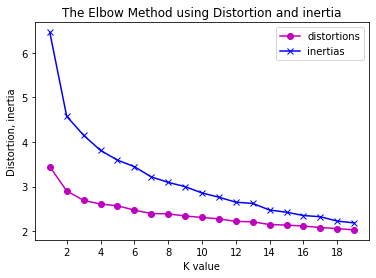

In [6]:
plt.title('The Elbow Method using Distortion and inertia') 
plt.plot(range(1,20), distortions, 'mo-')
plt.plot(K, inertias, 'bx-') 
plt.xlabel('K value')
plt.ylabel("Distortion, inertia")
plt.grid(color='white', linestyle='-', linewidth=5)
plt.xticks(np.arange(2, 20, 2))
plt.legend(['distortions', 'inertias'])
plt.show()


In [5]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(combined_grp_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 6, 2, 4, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 6, 2, 2, 6,
       5, 2, 2, 2, 6, 6, 5, 2, 2, 6, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 0, 2,
       2, 5, 2, 2, 2, 2, 2, 6, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 4, 6, 6, 2, 3, 2, 2, 0, 2, 2, 2,
       2, 3, 2, 2, 6, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 3, 2, 0, 6, 2, 6,
       6, 0, 6, 6, 2, 6, 6, 0, 0, 4, 4, 2, 2, 2, 0, 0, 0, 2, 2, 6, 6, 2,
       6, 6, 2, 6, 6, 2, 2, 2, 2, 0, 2, 2, 2, 3, 6, 6, 3, 0, 6, 2, 2, 6,
       6, 2, 6, 2, 3, 2, 2, 3, 2, 1, 3, 3, 3, 3, 3, 3, 0, 2, 0, 0, 2, 2,
       0, 2, 6, 6, 2, 4, 2, 3, 2, 1, 1, 6, 0, 6, 0, 2, 6, 6, 3, 3, 3, 2,
       3, 3, 3, 6, 4, 6, 4, 6, 1, 3, 3, 4, 3, 1, 1, 1, 3, 5, 3, 3, 2, 1,
       3, 3, 3, 6, 6, 3, 1, 1, 3, 3, 3, 2, 6, 2, 4, 6, 6, 3, 5, 6, 0, 6,
       6, 2, 4, 6, 6, 2, 6, 2, 3, 2, 4, 6, 2, 2, 0, 0, 2, 6, 6, 4, 2, 0,
       2, 0, 0, 2, 2, 6, 2, 2, 0, 6, 6, 0, 0, 0, 2, 6, 2, 2, 2, 6, 4, 2,
       2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 6, 0, 6, 2, 6,

##### Generate a database of borough + neighborhood + lat/long + cluster_id + top 10 venues¶

In [6]:
# add clustering labels
top_venues.insert(0, 'Cluster Label', kmeans.labels_)
top_venues.head()

,Cluster Label,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Toronto,North York,Parkwoods,43.753259,-79.329656,Lung Space,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Toronto,North York,Victoria Village,43.725882,-79.315572,Bakery and Cafe,Budget Food Joint,Restaurant,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN
2,6,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Bakery and Cafe,Basic Needs,Bar Pub etc,Health and Wellness,sports and entertainment,Lung Space,Restaurant,lifestyle,Essential Services,Market Place
3,2,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Basic Needs,lifestyle,Bakery and Cafe,Health and Wellness,Restaurant,NaN,NaN,NaN,NaN,NaN
4,4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Bakery and Cafe,Restaurant,Bar Pub etc,Basic Needs,Health and Wellness,sports and entertainment,Academic Institutes and Facilities,Budget Food Joint,Essential Services,Lung Space


In [7]:
combined_data_cluster = combined_venues_grp.iloc[:, 0:5]

# merge combined_data_cluster with top_venues to add latitude/longitude for each neighborhood
combined_data_cluster = combined_data_cluster.join(top_venues.set_index(['City', 'Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']), on=['City', 'Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'])
combined_data_cluster.head(-5)

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,2,Lung Space,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Toronto,North York,Victoria Village,43.725882,-79.315572,2,Bakery and Cafe,Budget Food Joint,Restaurant,sports and entertainment,NaN,NaN,NaN,NaN,NaN,NaN
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,6,Bakery and Cafe,Basic Needs,Bar Pub etc,Health and Wellness,sports and entertainment,Lung Space,Restaurant,lifestyle,Essential Services,Market Place
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Basic Needs,lifestyle,Bakery and Cafe,Health and Wellness,Restaurant,NaN,NaN,NaN,NaN,NaN
4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Bakery and Cafe,Restaurant,Bar Pub etc,Basic Needs,Health and Wellness,sports and entertainment,Academic Institutes and Facilities,Budget Food Joint,Essential Services,Lung Space
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,New York,Brooklyn,Madison,40.609378,-73.948415,2,Restaurant,Bakery and Cafe,Basic Needs,Budget Food Joint,Health and Wellness,NaN,NaN,NaN,NaN,NaN
395,New York,Bronx,Bronxdale,40.852723,-73.861726,2,Restaurant,Basic Needs,Bakery and Cafe,Budget Food Joint,Essential Services,Health and Wellness,sports and entertainment,NaN,NaN,NaN
396,New York,Bronx,Allerton,40.865788,-73.859319,4,Basic Needs,Budget Food Joint,Restaurant,Essential Services,Health and Wellness,Market Place,Academic Institutes and Facilities,Bakery and Cafe,Public Tpt System,sports and entertainment
397,New York,Bronx,Kingsbridge Heights,40.870392,-73.901523,4,Restaurant,Budget Food Joint,Bakery and Cafe,Public Tpt System,Bar Pub etc,Basic Needs,Lung Space,Academic Institutes and Facilities,Health and Wellness,NaN


#### Neighborhood venue characteristics

Efforts were made to characterise each cluster by mapping onto the various features identified during the **Exploratory Data Analysis**. Further, the two cities were compared through map depiction using **Folium**.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [13]:
#create map
ny_center = [ny_latitude, ny_longitude]
ny_map_clusters = folium.Map(location= ny_center, zoom_start=10.25)
ny_kclusters = kclusters

# set color scheme for the clusters
x = np.arange(ny_kclusters)
ys = [i + x + (i*x)**2 for i in range(ny_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
newyork_merged = combined_data_cluster.iloc[:, 2:6][combined_data_cluster['City'] == 'New York']
newyork_merged.rename(columns = {'Neighborhood Latitude': 'Latitude', 'Neighborhood Longitude': 'Longitude'}, inplace=True)

for lats, lons, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lats, lons],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(ny_map_clusters)
       

ny_map_clusters.save('ny_map_cluster.html') #saving the map as image        
ny_map_clusters


In [14]:
address = 'Toronto City, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
t_latitude = location.latitude
t_longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(t_latitude, t_longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [15]:
#create map
toronto_map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=10.25)
t_kclusters = kclusters

# set color scheme for the clusters
x = np.arange(t_kclusters)
ys = [i + x + (i*x)**2 for i in range(t_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
toronto_merged = combined_data_cluster.iloc[:, 2:6][combined_data_cluster['City'] == 'Toronto']
toronto_merged.rename(columns = {'Neighborhood Latitude': 'Latitude', 'Neighborhood Longitude': 'Longitude'}, inplace=True)

for lats, lons, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lats, lons],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(toronto_map_clusters)
       

toronto_map_clusters.save('toronto_map_cluster.html') #saving the map as image        
toronto_map_clusters


**Findings: -**  
Comparison of the two maps reveals the following: -
- New York has much more number of neighborhoods as compared to Toronto. This indicates that New York is bigger and more crowded
- New York has a good mix of all the clusters. Whereas, Toronto has predominantly **Cluster 2** (marked by **Cyan** markers). This indictaes that New York has more options in choosing neighborhoods suiting to different needs.

**Quantitative analysis**
> a. **Topmost and least common venues in each cluster**.  

> The database **combined_data_cluster** was used to compute frequencies of various venue types in each cluster and arrange them in decreasing order. The output was used to generate a **Heatmap** of **Cluster** Vs **Venue Categories**.

In [19]:
def stat(top_1, top_2, top_3):
    x = pd.DataFrame(top_1)
    y = pd.DataFrame(top_2)
    z = pd.DataFrame(top_3)

    x.columns = ['Count']
    y.columns = ['Count']
    z.columns = ['Count']
    w = x.index.union(y.index.union(z.index))

    count1 = [0 for cnt in range(w.shape[0])]

    for n in range(w.shape[0]):
        temp1 = w[n]
        for m in range(x.shape[0]):
            if x.index[m] == temp1:
                count1[n] = count1[n] + x.iloc[m, 0]
        for m in range(y.shape[0]):
            if y.index[m] == temp1:
                count1[n] = count1[n] + y.iloc[m, 0]
        for m in range(z.shape[0]):
            if z.index[m] == temp1:
                count1[n] = count1[n] + z.iloc[m, 0]

    top_cnt = [w, count1]
    top_cnt = pd.DataFrame(top_cnt)
    top_cnt = top_cnt.T  
    
    return top_cnt

In [20]:
def cluster_feature(df, i, j, k, l):       # df = input cluster df, i = No of clusters, j = No. of top features, k = No. of bottom features
                                           # l = location of 'Cluster Labels'

    cluster_dist = df.iloc[:, l-1].groupby(df.iloc[:, l-1]).count()

    #create output dataframe and initialise
    temp = [0 for t in range(j+k+1)]
    temp = pd.DataFrame(temp, columns = ['Cluster Id'])

    for count in range(j):
        col = 'Top' + str(count+1)
        temp[col] = 0

    for count in range(k):
        col = 'Last' + str(k-count)
        temp[col] = 0

    for count in range(i):
        df_cluster = df[df.iloc[:, l-1]==count]
        top_1 = df_cluster['1st Most Common Venue'].groupby(df_cluster['1st Most Common Venue']).count().sort_values(ascending=False).head(3)
        top_2 = df_cluster['2nd Most Common Venue'].groupby(df_cluster['2nd Most Common Venue']).count().sort_values(ascending=False).head(3)
        top_3 = df_cluster['3rd Most Common Venue'].groupby(df_cluster['3rd Most Common Venue']).count().sort_values(ascending=False).head(3)

        bottom_1 = df_cluster['10th Most Common Venue'].groupby(df_cluster['10th Most Common Venue']).count().sort_values(ascending=False).head(3)
        bottom_2 = df_cluster['9th Most Common Venue'].groupby(df_cluster['9th Most Common Venue']).count().sort_values(ascending=False).head(3)
        bottom_3 = df_cluster['8th Most Common Venue'].groupby(df_cluster['8th Most Common Venue']).count().sort_values(ascending=False).head(3)
        
        top_cnt = stat(top_1, top_2, top_3)  
        lst_cnt = stat(bottom_3, bottom_2, bottom_1)
        
        top_cnt.columns = ['Category', 'total Count']
        top_cnt = top_cnt.sort_values('total Count', ascending = False).reset_index(drop=True).head(j)

        lst_cnt.columns = ['Category', 'total Count']
        lst_cnt = lst_cnt.sort_values('total Count', ascending = False).reset_index(drop=True).head(k)

        temp.iloc[count, 0] = count
        
        for cnt in range(j):
            temp.iloc[count, cnt+1] = top_cnt.iloc[cnt, 0]

        for cnt in range(k):
            temp.iloc[count, cnt+j+1] = lst_cnt.iloc[cnt, 0]

    return temp


In [21]:
cluster_matrix = cluster_feature(combined_data_cluster, kclusters, 3, 3, 6)
cluster_matrix.set_index("Cluster Id", inplace=True)
cluster_matrix

,Top1,Top2,Top3,Last3,Last2,Last1
Cluster Id,,,,,,
0,Public Tpt System,Restaurant,Basic Needs,sports and entertainment,lifestyle,Market Place
1,Restaurant,Bakery and Cafe,Basic Needs,lifestyle,Lung Space,sports and entertainment
2,Restaurant,Basic Needs,Bakery and Cafe,Public Tpt System,lifestyle,Lung Space
3,Restaurant,Basic Needs,Bakery and Cafe,Market Place,lifestyle,Hotel Lodge etc
4,Restaurant,Basic Needs,Bakery and Cafe,sports and entertainment,Academic Institutes and Facilities,Essential Services
5,Bakery and Cafe,Restaurant,Basic Needs,Business Facility,Lung Space,Hotel Lodge etc
6,Restaurant,Basic Needs,Bakery and Cafe,Market Place,Public Tpt System,lifestyle


In [22]:
groups = combined_venues_grp.columns
groups = groups[5:]

cluster_heatmap = pd.DataFrame(index = cluster_matrix.index, columns = groups)
cluster_heatmap.iloc[:,:] = 0

heat_list = cluster_heatmap.columns

for cluster in (cluster_heatmap.index):
    for i in range(len(cluster_matrix.columns)):
        for j in range(len(cluster_heatmap.columns)):
            if (heat_list[j] == cluster_matrix.iloc[cluster, i]) & (cluster_heatmap.iloc[cluster, j] == 0):
                cluster_heatmap.iloc[cluster, j] = len(cluster_matrix.columns)-i

cluster_heatmap = cluster_heatmap.astype({col:int for col in cluster_heatmap.columns})
cluster_heatmap.drop(['Bar Pub etc', 'Budget Food Joint', 'Health and Wellness', 'mall_plaza_supermarket'], 1, inplace=True)
cluster_heatmap

,Academic Institutes and Facilities,Bakery and Cafe,Basic Needs,Business Facility,Essential Services,Hotel Lodge etc,Lung Space,Market Place,Public Tpt System,Restaurant,lifestyle,sports and entertainment
Cluster Id,,,,,,,,,,,,
0,0,0,4,0,0,0,0,1,6,5,2,3
1,0,5,4,0,0,0,2,0,0,6,3,1
2,0,4,5,0,0,0,1,0,3,6,2,0
3,0,4,5,0,0,1,0,3,0,6,2,0
4,2,4,5,0,1,0,0,0,0,6,0,3
5,0,6,4,3,0,1,2,0,0,5,0,0
6,0,4,5,0,0,0,0,3,2,6,1,0


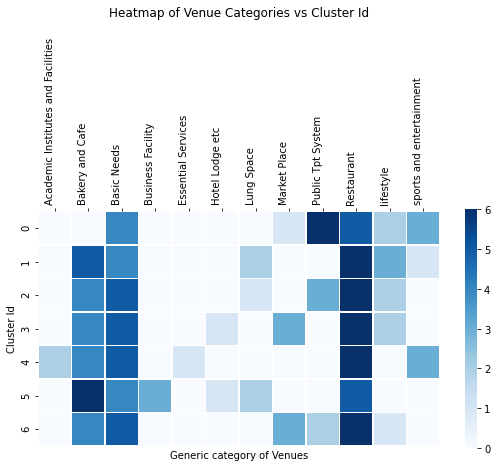

In [23]:
fig, ax = plt.subplots(figsize=(9, 11))
sb.heatmap(cluster_heatmap, cmap="Blues", vmin= 0, vmax=6, square=True,
           linewidth=0.5, cbar_kws={"shrink": .4})
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.xlabel("Generic category of Venues")
plt.title("Heatmap of Venue Categories vs Cluster Id\n", fontsize = 12)

plt.show()

> **Findings: -**  
> The above Heatmap depicts the Venue Categories in shades of Blue - darkest shade (value 6) indicates **Topmost Common Venue** and lightest shade (score 0) indicates **Least Common Venue**.   

> - It is seen that **Restaurant**, **Basic Needs** and **Bakery and Cafe** are the most prominent venue categories.  

> - A rather curious and unexpecrted observation is that **Essential Services** and **Hotel Lodge etc** are the **Least Common Venues**. This is not the case in reality. The reason most probably is that the  database in nthis project contains venues within 500 metre radius of the neighborhood centres. In most localities, these facilities would be located beyond 500 metres.  

> b. **Clusterwise statistics of top venue distribution in the two cities**   

> The database **combined_data_cluster** was split into New York and Toronto databases. For each city, **line plot** was generated - one for each cluster by joining the frequency plot of each venue type. The venue types were arranged in decreasing order as **1st Most Common Venue**, **2nd Most Common Venue**, ... **10th Most Common Venue**.

In [29]:
city_dist = combined_data_cluster.groupby([combined_data_cluster['Cluster Label'], combined_data_cluster['City']]).count()
city_dist = city_dist.drop(['Borough', 'Neighborhood Latitude', 'Neighborhood Longitude'], 1)
city_dist

Neighborhood  1st Most Common Venue  \
Cluster Label City                                            
0             New York            48                     48   
              Toronto              3                      3   
1             New York            17                     17   
              Toronto              2                      2   
2             New York           119                    119   
              Toronto             70                     69   
3             New York            37                     37   
              Toronto              2                      2   
4             New York            17                     17   
              Toronto              4                      4   
5             New York             5                      5   
              Toronto              7                      7   
6             New York            62                     62   
              Toronto             11                     11   

                        2nd Most Common Venue  3rd Most Common Venue  \
Cluster Label City                                                     
0             New York                     48                     46   
              Toronto                       3                      3   
1             New York                     17                     17   
              Toronto                       2                      2   
2             New York                    110                    106   
              Toronto                      63                     55   
3             New York                     37                     37   
              Toronto                       2                      2   
4             New York                     17                     17   
              Toronto                       4                      4   
5             New York                      5                      5   
              Toronto                       7                      7   
6             New York                     62                     62   
              Toronto                      11                     11   

                        4th Most Common Venue  5th Most Common Venue  \
Cluster Label City                                                     
0             New York                     41                     41   
              Toronto                       3                      3   
1             New York                     17                     17   
              Toronto                       2                      2   
2             New York                     97                     79   
              Toronto                      43                     29   
3             New York                     37                     37   
              Toronto                       2                      2   
4             New York                     17                     17   
              Toronto                       2                      2   
5             New York                      5                      5   
              Toronto                       7                      7   
6             New York                     62                     62   
              Toronto                      11                     11   

                        6th Most Common Venue  7th Most Common Venue  \
Cluster Label City                                                     
0             New York                     35                     32   
              Toronto                       1                      1   
1             New York                     17                     17   
              Toronto                       2                      2   
2             New York                     61                     40   
              Toronto                      22                     11   
3             New York                     37                     37   
              Toronto                       2                

In [30]:
city_dist.reset_index(inplace=True) 
city_dist_toronto = city_dist[city_dist['City']=='Toronto']
city_dist_toronto.drop(['City', 'Neighborhood'], 1, inplace=True)
city_dist_toronto.set_index('Cluster Label', inplace = True)

city_dist_newyork = city_dist[city_dist['City']=='New York']
city_dist_newyork.drop(['City', 'Neighborhood'], 1, inplace=True)
city_dist_newyork.set_index('Cluster Label', inplace = True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


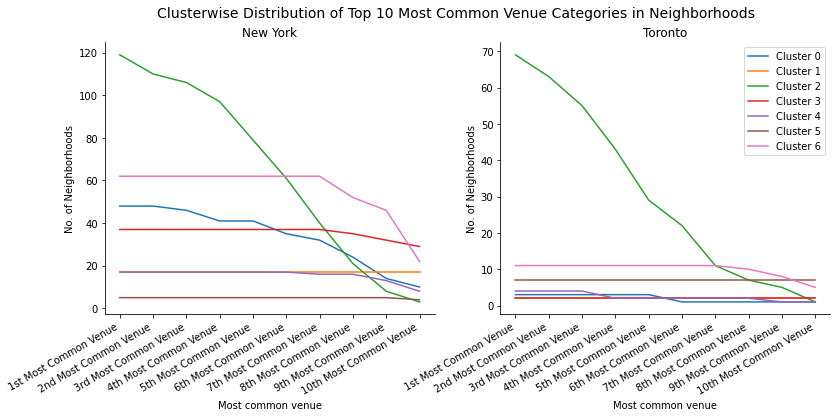

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# New York plots
axs[0].set_title('New York')
axs[1].set_title('Toronto')

for i in city_dist_newyork.index:
    axs[0].plot(city_dist_newyork.iloc[i, :])

axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)

# Toronto plots

legend = ["" for i in city_dist_toronto.index]     # One legend will suffice for both sub-plots

for i in city_dist_toronto.index:
    axs[1].plot(city_dist_toronto.iloc[i, :])
    legend[i] = "Cluster " + str(i)
    axs[1].legend(legend)

axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='Most common venue', ylabel='No. of Neighborhoods')


plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.suptitle("Clusterwise Distribution of Top 10 Most Common Venue Categories in Neighborhoods\n\n", fontsize=14)

plt.show()

> **Findings: -**  
> The graphs depict some interesting results, as brought out below: -
> - Cluster 2 graph drops sharply beyond 4th Most Common Venue. This indicates that most neighborhoods in this cluster have only four types of venues which are prominent. 
> - In both the cities, Cluster 2 contains the largest number of neighborhoods. This implies that the remaining clusters either have exclusive localities (better lifestyle) or not-so-developed ones.
> - **Toronto** has very few neighborhoods in **Cluster 0, 1, 3, 4 and 5** (in single digit). Clusetr 6 has 11 neighborhoods. **Interestingly, most neighborhoods in all these clusters have all the ten types of venues included in the analysis**. 
> - Likewise, most of the **New York** neighborhoods in **Cluster 1, 3, 4 and 5 have all the ten types of venues** that were considered for the analysis.

#### combined_data_cluster.to_csv('combined_data_cluster.csv', index=False)

In [5]:
combined_data_cluster=pd.read_csv('combined_data_cluster.csv')

> c. **Cluster to Feature mapping**  

> This analysis is a **crucial** one - it is the culmination of all the analysis done so far. Objective of this analysis is to identify the **Features** presnt in each cluster. This would **enable one to recommend cluster (and neighborhoods in the cluster) for relocation, depending on the individual's needs**.  

> Computation was performed to find out how many of the **top 15 neighborhoods** in each **Feature** belong to a certain cluster. **Assuming that each cluster is internally homogenous, this statistics would provide an indication of the cluster characteristics.**

In [64]:

def match_percent(combined_df, clusters, top_15, feature_list):     
    neighborhood_cluster = combined_df[['Borough', 'Neighborhood', 'Cluster Label']]     # combined_df = combined_data_cluster
    collection = []
    collection = pd.DataFrame(collection)
    
    for i in range(len(feature_list)):

        top_feature = top_15[i]

        top_feature.reset_index(inplace=True)
 
        top_feature = top_feature[['Borough', 'Neighborhood']]

        cluster_feature_match = top_feature.join(neighborhood_cluster.set_index(['Borough', 'Neighborhood']), on = ['Borough','Neighborhood'])
        
        cluster_feature_match_percent = cluster_feature_match[['Cluster Label', 'Neighborhood']].groupby(['Cluster Label']).count()
        cluster_feature_match_percent['Proportion'] = round((cluster_feature_match_percent['Neighborhood']/(cluster_feature_match_percent['Neighborhood'].sum()))*100, 2)
        cluster_feature_match_percent['Feature'] = feature_list[i]
        
        for j in range(clusters):
            exists = j in cluster_feature_match_percent.index
            if (exists == False):
                data = [{'Cluster Label': j, 'Neighborhood': 0, 'Proportion': 0, 'Feature': feature_list[i]}]
                x = pd.DataFrame(data)
                x.set_index('Cluster Label', inplace=True)
                collection = collection.append(x)

        collection.sort_index(axis=0, inplace=True)
        collection = collection.append(cluster_feature_match_percent)
        del top_feature

    collection.sort_index(axis=0, inplace=True)
        
    return collection

In [65]:
clusterwise_feature_dist = match_percent(combined_data_cluster, kclusters, [eatery_15, lifestyle_15, professionals_need_15, student_needs_15, fitness_15, daily_life_15], ['eatery', 'lifestyle', 'professionals', 'student', 'fitness', 'daily_life'])

eatery_15.set_index(['Borough', 'Neighborhood'], inplace=True)
lifestyle_15.set_index(['Borough', 'Neighborhood'], inplace=True)
professionals_need_15.set_index(['Borough', 'Neighborhood'], inplace=True)
student_needs_15.set_index(['Borough', 'Neighborhood'], inplace=True)
fitness_15.set_index(['Borough', 'Neighborhood'], inplace=True)
daily_life_15.set_index(['Borough', 'Neighborhood'], inplace=True)

#clusterwise_feature_dist.sort_index(axis=0, inplace=True)
clusterwise_feature_dist.reset_index(inplace=True)

clusterwise_feature_dist

,Cluster Label,Neighborhood,Proportion,Feature
0,0,0,0.00,eatery
1,0,2,13.33,lifestyle
2,0,0,0.00,student
3,0,1,6.67,professionals
4,0,0,0.00,fitness
5,0,0,0.00,daily_life
6,1,6,40.00,lifestyle
7,1,1,6.67,daily_life
8,1,4,26.67,eatery
9,1,9,60.00,fitness


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


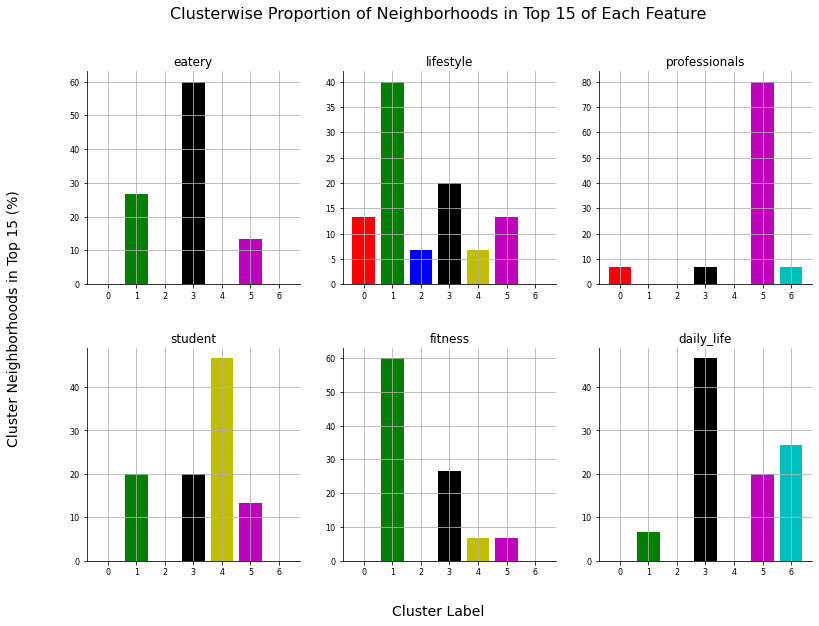

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(13, 9), gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

feature_list = ['eatery', 'lifestyle', 'professionals', 'student', 'fitness', 'daily_life']
color = ['blue', 'cyan', 'magenta', 'green', 'purple', 'yellow']
#Plot the data:
my_colors = 'rgbkymc'  #red, green, blue, black, etc.


# Set Features as plot titles
for i in range(2):
    for j in range(3):
        axs[i, j].set_title("\n"+feature_list[3*i+j])
        axs[i, j].spines["right"].set_visible(False)
        axs[i, j].spines["top"].set_visible(False)
        x=clusterwise_feature_dist['Cluster Label'][clusterwise_feature_dist['Feature']==feature_list[3*i+j]]
        y=clusterwise_feature_dist['Proportion'][clusterwise_feature_dist['Feature']==feature_list[3*i+j]]
        axs[i, j].bar(x, y, color = my_colors, )   #color[3*i+j])
#        pd.Series.plot([x, y], kind='bar', color=my_colors,)
        axs[i, j].grid()
        axs[i, j].tick_params(axis='both', which='both', labelsize=8)

        for tick in axs[i, j].get_xticklabels():
            tick.set_visible(True)
        #        axs[i, j].tick_params(top=False, bottom=True, left=False, right=False)   # labelcolor='b', 
#        axs[i, j].set_xlabel("Cluster Label")
        
#for ax in axs.flat:
#    ax.set(xlabel='Cluster Label')  #, ylabel='Cluster Neighborhoods in Top 15 (%)')
    
fig.text(0.5, 0.04, 'Cluster Label', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Cluster Neighborhoods in Top 15 (%)', va='center', rotation='vertical', fontsize=14)

plt.suptitle("Clusterwise Proportion of Neighborhoods in Top 15 of Each Feature", fontsize=16)

plt.show()

In [18]:
cluster_list = {'Cluster 0': ['lifestyle'], 'Cluster 1': [['eatery', 'lifestyle', 'student', 'fitness']],
                'Cluster 2': ['average lifestyle'],'Cluster 3': [['eatery', 'lifestyle', 'student', 'fitness', 'daily_life']],
                'Cluster 4': ['student'], 'Cluster 5': [['lifestyle', 'professionals', 'daily_life']],'Cluster 6': ['daily_life']}

cluster_list = pd.DataFrame(cluster_list)
cluster_list=cluster_list.T
cluster_list.rename(columns= {0: 'Suitability'}, inplace = True)
cluster_list

,Suitability
Cluster 0,lifestyle
Cluster 1,"[eatery, lifestyle, student, fitness]"
Cluster 2,average lifestyle
Cluster 3,"[eatery, lifestyle, student, fitness, daily_life]"
Cluster 4,student
Cluster 5,"[lifestyle, professionals, daily_life]"
Cluster 6,daily_life


In [60]:
clusterwise_feature_dist[['Feature', 'Proportion', 'Cluster Label']].sort_values(['Feature', 'Proportion'], ascending=False)

,Feature,Proportion,Cluster Label
23,student,46.67,4
8,student,20.00,1
18,student,20.00,3
28,student,13.33,5
2,student,0.00,0
16,student,0.00,2
36,student,0.00,6
30,professionals,80.00,5
3,professionals,6.67,0
21,professionals,6.67,3


> **Findings: -**  
> The graphs depict proportion of neighborhoods out of the Top 15 list present in each cluster. Separate graphs have been plotted for each **Feature**.  
> The following emerge from study of the graphs: -  
> - **Cluster 1** has the highest proportion of **Top 15** neighborhoods in **"lifestyle" Feature** and **"fitness" Feature**  
> - Likewise, highest proportion of neighborhoods out of **Top 15** in **"eatery" Feature** and **"daily_life" Feature** are present in **Cluster 3** 
> - **Cluster 4** has the highest proportion of **Top 15** neighborhoods in **"student" Feature**
> - **Cluster 5** has the highest proportion of **Top 15** neighborhoods in **"professionals" Feature**  

>An interesting observation is that **Cluster 2** doesn't have any presence in the **Top 15** in any **Feature**, except **"lifestyle"** (only 6.67%). This impllies that **Cluster 2** has moderate density of venues in all the categories, offering a **decent, affordable lifestyle and moderately crowded neighborhoods**.  

> **As was observed in the map, Cluster 2 is the most prominent cluster in Toronto**.   



## 5. Results and Discussion

The analysis was done in three levels: -  

1. **City-level** - Comparison of the two cities in terms of the venue types and venue density (within a radius of 500 metre from mneighborhood centre)  

2. **Cluster-level** - Clustering, characterisation of each cluster and mapping them to the Features  

3. **Neighborhood-level**  
> - Comparison of neighborhoods in terms of the **venue catrgories** and **venue density**  
> - Comparison of neighborhoods in terms of **Features**  


**Salient results obtained are summarised below**  

Based on the available venue data, it was possible to characterise neighborhoods, cities and clusters. The characterisation was helpful in classifying/ recommending the neighborhoods based on the relocation objectives (defined as **Features**).  

**City-level**: -  

> a. New York has much more number of neighborhoods as compared to Toronto. Number of venues in New York are also much more than Toronto. These findings indicate that New York is bigger and more crowded  

> b. New York has a good mix of all the clusters. Whereas, Toronto has predominantly **Cluster 2** (marked by **Blue** markers). This indictaes that New York has more options in choosing neighborhoods suiting to different needs.  

> c. In both the cities, **"Restaurant"** is the most common venue among all generic categories.  


**Cluster-level: -**  

> Clusters have been identified for relocation, based on the needs of the individuals.  

- #### Clusters' suitability for relocation is as per the following matrix: - 

In [19]:
cluster_list

,Suitability
Cluster 0,lifestyle
Cluster 1,"[eatery, lifestyle, student, fitness]"
Cluster 2,average lifestyle
Cluster 3,"[eatery, lifestyle, student, fitness, daily_life]"
Cluster 4,student
Cluster 5,"[lifestyle, professionals, daily_life]"
Cluster 6,daily_life


**Neighborhood-level: -**  

>a. **"Restaurant"**, **"Basic Needs"** and **"Bakery and Cafe"** are the **three most common venues** in majority of the neighborhoods. Availability of these venues as the most common ones indicate that such neighborhoods are well-populated residential areas. Prefered by those who would relocate for jobs and decent living.    

>b. Neighborhoods with most common venues **"Lifestyle"** and **"Lung Space"** are the high-cost-of-living areas. Suitable for those looking to relocate for enjoying a relaxed and premium lifestyle. 

>c. The neighborhoods with **"Budget Food Joint"** as the  most common venue offers affordable living. Such neighborhoods would be prefered  by students for relocation.  

>d. Venue categories **"Bakery and Cafe"**, **"Bar Pub etc"**, **"Basic Needs"**, **"Health and Wellness"** and **"Restaurant"** have **high correlation** (> 0.6). This implies that neighborhoods which have any of these categories as the most common venues, are likely to have the other categories as well.  

- #### Database of Top 15 Neighborhoods suited for relocation in each need category (i.e., Feature) are : - ####  

> **[eatery_15, lifestyle_15, professionals_need_15, student_needs_15, fitness_15, daily_life_15]**  


- #### There are **outliers** which do not fit into any relocation criteria due to lack of the required **features**.

  



### Discussions ###  
There was good coherence between **Exploratory Data Analysis** and **Clustering** results. Both analysis established that New York has more diversity of neighborhood types as compared to Toronto. The Clustering algorithm created clusters based on the needs of the individuals (defined as **Features** in the project). 

However, clusters were not entirely distinct; there are overlaps of multiple **Features**. This is expected, because, the various needs of relocation cannot be totally different from each other. For example, an individual looking to relocate for better quality of life would also look for food restaurant and health facilities, besides having adequate **"lung space"** in the neighborhood.  

For the data gathered through **Foursquare** in this project, the **elbow-method graph** did not have well-defined elbow. As a result, the number of clusters may not be the most optimum. This would affect formation of well-defined clusters which are distinct from each other. Improving the clustering result may be possible if the radius around the neighborhood centre is increased for venue analysis or alternate algorithms are chosen for clustering. However, this was not attempted as it was out of the scope of the project.    

## 6. Conclusion

The objective of this project was **to evolve a method to identify distinct characteristics of the neighborhoods in the two cities**, based solely on details of venues in the neighborhoods. Once such characteritics were established, the **neighborhoods were to be categorised for relocation such that each category fullfills a definite set of needs (such as better quality of life, living within a budget etc)**. 

Towards this end, we have been sucessful to evolve metrics which can be useful to categorise the neighborhoods. We were also able to draw indirect inferences as to the cost of living, whether the residents are high income group etc., **without even refering to the Census data**.       

The results of the project can be useful in many ways, beyond making a decision on relocating to a neighborhood (which was the main objective of the project). One such example is that the **outliers** which do not have adequate **"eatery", "lung space" or "health facility"** etc can be taken up for development and provisioing of public amenities. Another utility of the project results is that, a business person can target such **outlier** neighborhoods for setting up his/her business.

Success of the approach adopted in the project would depend to a large extent on the venue database and how the appropriate attributes for clustering are chosen. Another aspect is the choice of the Clustering algorithm (e.g.DBSCAN). The implementation can be made more robust through experimentation in these regards.  

The database generated by Foursquare is dynamic. Hence, the venue database instance created using Foursquare app needs to be “frozen” so as to obtain consistency in the results. 